#Data Import


In [ ]:
!pip install -q import_ipynb
!pip install -q tensorflow_addons
from google.colab import drive
import sys
import tensorflow as tf
import tensorflow_addons as tfa
from keras.models import Model
from keras.layers import Input
from tensorflow.keras.layers import Input, Conv1D, ReLU, BatchNormalization,\
                                    Add, AveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = '14'

import import_ipynb
from Analysis_branch import AnalysisBranch1D
from Synthesis_Branch import SynthesisBranch1D
from Summing_unit_for_synthesis import Add1D
from Pywavelets import ImpulseRespones2BPRFB
#from Trainable_1D_Conv import Conv1DBNMish

In [ ]:
import keras
from keras.layers import Activation
from keras.applications.efficientnet import EfficientNetB3

from keras.models import Model
from keras.layers import Input, Dense, Flatten, Dropout
from keras.callbacks import History 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:

training_data = pd.read_csv (r'training.csv')
testing_data = pd.read_csv(r'testing.csv')


# Data Preprocessing

In [ ]:

training_data = pd.read_csv (r'training.csv')
testing_data = pd.read_csv(r'testing.csv')

training_data = training_data[training_data["Temp"].str.contains("  NaN") == False]

testing_data = testing_data[testing_data["Temp"].str.contains("  NaN") == False]
testing_data = testing_data[testing_data["RH"].str.contains("  NaN") == False]

# removing the date column
training_data = training_data.iloc[: , 1:]
training_data = training_data.dropna()

testing_data = testing_data.iloc[: , 1:]
testing_data = testing_data.dropna()

# keeping the height and channels in x_train 
x_train = training_data.iloc[: , :23]
x_train = x_train.reset_index()
x_train = x_train.drop(columns=['index'])

# keeping the weather parameters in y_train
y_train = training_data.iloc[: , 23:]
y_train = y_train.reset_index()
y_train = y_train.drop(columns=['index'])


# repeating same steps for test data
x_test = testing_data.iloc[: , :23]
x_test = x_test.reset_index()
x_test = x_test.drop(columns=['index'])


y_test = testing_data.iloc[: , 23:]
y_test = y_test.reset_index()
y_test = y_test.drop(columns=['index'])



In [ ]:

# changing from pandas to numpy and dropping columns with NaN values
x_train = x_train.to_numpy()
y_train = y_train.to_numpy()
indexList = [np.any(i) for i in np.isnan(x_train)]
x_train = np.delete(x_train, indexList, axis=0)

x_test = x_test.to_numpy()
y_test = y_test.to_numpy()
indexList = [np.any(i) for i in np.isnan(x_test)]
x_test = np.delete(x_test, indexList, axis=0)

In [ ]:
# converting all values in array to float
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')
x_test = x_test.astype('float32')
y_test = y_test.astype('float32')



In [ ]:
# the shape of all arrays can be now visualised
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(9389, 23)
(9389, 3)
(4258, 23)
(4258, 3)


# Model Creation

In [ ]:
err = lambda xn, xn_hat:np.round(np.sum(abs((xn-xn_hat.T)[0]/xn))/len(xn) * 100,5)
global h0n, h1n, g0n, g1n


mother_wavelet = 'coif1'  # <<----

w = ImpulseRespones2BPRFB(mother_wavelet)
h0n, h1n = w.analysis()
g0n, g1n = w.synthesis()

filt_len = len(h0n)
del w

In [ ]:
# define system parameters
lr = 10e-4
input_shape = 23,1
bs = 300
num_epochs = 1000
val_split = 0.10


In [ ]:


# Define the input layer
inputs = Input(input_shape)

# Define the encoder layers
encoder_block1 = layers.MultiHeadAttention(num_heads=18, key_dim=64, dropout=0.1)
encoder_block2 = layers.MultiHeadAttention(num_heads=8, key_dim=64, dropout=0.3)
encoder_block3 = layers.MultiHeadAttention(num_heads=8, key_dim=64, dropout=0.3)
encoder_dense = layers.Dense(32, activation=lambda x: tfa.activations.mish(x))

# Define the decoder layers
decoder_block1 = layers.MultiHeadAttention(num_heads=18, key_dim=64, dropout=0.1)
decoder_block2 = layers.MultiHeadAttention(num_heads=8, key_dim=64, dropout=0.2)
decoder_block3 = layers.MultiHeadAttention(num_heads=8, key_dim=64, dropout=0.3)
decoder_dense = layers.Dense(1, activation=lambda x: tfa.activations.mish(x))

# Encode the input sequence
encoded = encoder_block1(inputs, inputs)
encoded = encoder_block2(encoded, encoded)
encoded = encoder_block3(encoded, encoded)
encoded = encoder_dense(encoded)

# Decode the hidden representation
decoded = decoder_block1(encoded, encoded)
decoded = decoder_block2(decoded, encoded)
decoded = decoder_block3(decoded, encoded)
decoded = decoder_dense(decoded)
# output=Flatten()(decoded)
# output=Dense(1)(output)

# Define the model
model = keras.Model(inputs=inputs, outputs=decoded)

# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss="MeanSquaredError", metrics=["accuracy"])
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 23, 1)]      0           []                               
                                                                                                  
 multi_head_attention_26 (Multi  (None, 23, 1)       8065        ['input_12[0][0]',               
 HeadAttention)                                                   'input_12[0][0]']               
                                                                                                  
 multi_head_attention_27 (Multi  (None, 23, 1)       3585        ['multi_head_attention_26[0][0]',
 HeadAttention)                                                   'multi_head_attention_26[0][0]']
                                                                                            

In [ ]:
encoder_block1 = layers.MultiHeadAttention(num_heads=18, key_dim=64, dropout=0.1)
decoder_block1 = layers.MultiHeadAttention(num_heads=18, key_dim=64, dropout=0.1)


lstm1 = tf.keras.layers.LSTM(50,return_sequences=True)
lstm2 = tf.keras.layers.LSTM(50,return_sequences=True)
gru = tf.keras.layers.GRU(50,return_sequences=True)


def Conv1Duser(inputs:tf) -> tf:
    cnn_layer = tf.keras.layers.Conv1D(filters=1,kernel_size=30,padding='same')
    inputs = cnn_layer(inputs)
    x = BatchNormalization()(inputs)
    return tfa.activations.mish(x)

def Conv1Duser_2(inputs:tf) -> tf:
    cnn_layer = tf.keras.layers.Conv1D(filters=1,kernel_size=25,padding='same')
    inputs = cnn_layer(inputs)
    x = BatchNormalization()(inputs)
    return tfa.activations.mish(x)

def dwt_2BPRFB(input_shape:tuple):
    
    global h0n, h1n, g0n, g1n

    inputs = Input(input_shape)
    inputs = encoder_block1(inputs, inputs)

    ##Analysis FB
    Ψ1 = AnalysisBranch1D(h1n)(inputs)
    ϕ1 = AnalysisBranch1D(h0n)(inputs)
    
    T1 = lstm1(ϕ1)
    
    #T1=Conv1Duser(ϕ1)
    T1 = gru(T1)
    T1 = lstm1(ϕ1)
    Temp=tf.concat([T1,Ψ1],2)
  
    #T2=Conv1Duser(Temp)
    T2 = lstm2(Temp)
    T2 = lstm2(Temp)


    #T2=Conv1Duser(Ψ1)
    Temp2=tf.concat([T1,T2],2)

    output=Conv1Duser_2(Temp2)
    output = decoder_block1(output,output)
    output=Flatten()(output)
    output=Dense(1)(output)

    ##Synthesis FB
    #p_part1 = SynthesisBranch1D(g1n)(T2)
    #p_part2 = SynthesisBranch1D(g0n)(T1)
    #output = Add1D(g0n)([p_part1, p_part2])

    model = Model(inputs=inputs, outputs=output)
    model.summary()
    
    return model

In [ ]:
model = dwt_2BPRFB(input_shape)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss='MeanSquaredError', metrics=['accuracy'])


Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22 (InputLayer)          [(None, 23, 1)]      0           []                               
                                                                                                  
 analysis_branch1d_17 (Analysis  (None, 14, 1)       7           ['input_22[0][0]']               
 Branch1D)                                                                                        
                                                                                                  
 lstm_16 (LSTM)                 (None, 14, 50)       10400       ['analysis_branch1d_17[1][0]']   
                                                                                                  
 analysis_branch1d_16 (Analysis  (None, 14, 1)       7           ['input_22[0][0]']        

In [ ]:
'''
k_band = RH         First 8 features + height
v_band = Temp       Last 14 features + height
'''

x_fit = tf.constant(x_train, dtype=tf.float32, name='x_train')
x_fit = tf.reshape(x_fit, [len(x_fit),len(x_fit[0]), 1])

y_fit = tf.constant(y_train[:,2], dtype=tf.float32, name='y_train')
y_fit.shape[0]
y_fit = tf.reshape(y_fit, [9389,1])

print(x_fit.shape)
print(y_fit.shape)


(9389, 23, 1)
(9389, 1)


# Training

In [ ]:

history = model.fit(
    x_fit,
    y_fit,
    batch_size=bs,
    epochs=num_epochs,
    validation_split=val_split,
)

Epoch 1/1000
29/29 [==============================] - 9s 79ms/step - loss: 4186.8267 - accuracy: 0.0000e+00 - val_loss: 2358.1128 - val_accuracy: 0.0000e+00
Epoch 2/1000
29/29 [==============================] - 1s 21ms/step - loss: 3348.3342 - accuracy: 1.1834e-04 - val_loss: 1853.0459 - val_accuracy: 0.0000e+00
Epoch 3/1000
29/29 [==============================] - 1s 23ms/step - loss: 893.2360 - accuracy: 1.1834e-04 - val_loss: 360.0301 - val_accuracy: 0.0000e+00
Epoch 4/1000
29/29 [==============================] - 1s 23ms/step - loss: 288.3271 - accuracy: 1.1834e-04 - val_loss: 336.6565 - val_accuracy: 0.0000e+00
Epoch 5/1000
29/29 [==============================] - 1s 23ms/step - loss: 263.4538 - accuracy: 1.1834e-04 - val_loss: 337.6046 - val_accuracy: 0.0000e+00
Epoch 6/1000
29/29 [==============================] - 1s 23ms/step - loss: 257.9835 - accuracy: 1.1834e-04 - val_loss: 307.6566 - val_accuracy: 0.0000e+00
Epoch 7/1000
29/29 [==============================] - 1s 21ms/step

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [ ]:
train_loss = (history.history['loss'])
val_loss = (history.history['val_loss'])

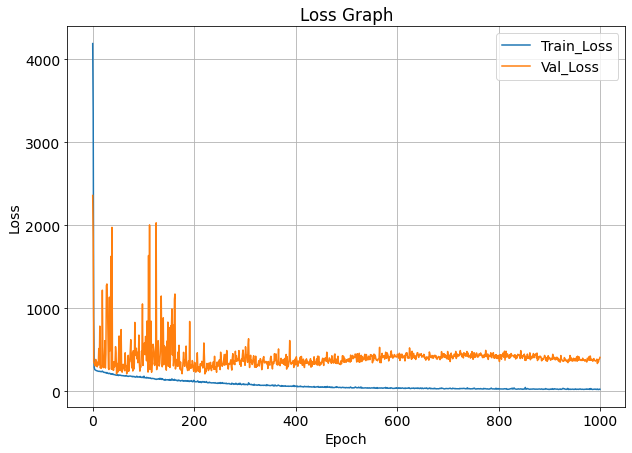

In [ ]:
plt.figure(figsize=(10,7))
plt.title("Loss Graph")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.plot(train_loss)
plt.plot(val_loss)

plt.legend(['Train_Loss','Val_Loss'])

In [ ]:
np.save('train_loss_march23_2300.npy', train_loss) # save
np.save('val_loss_march23_2300.npy', val_loss) # save

# new_arr = np.load('train_loss_march23_2300.npy') # load

# Evaluation

In [ ]:
from keras.models import load_model

model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
# del model  # deletes the existing model

# returns a compiled model
# identical to the previous one

In [ ]:

new_model = load_model('my_model.h5')

ValueError: ignored

134/134 [==============================] - 1s 7ms/step


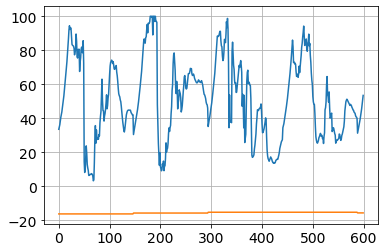

In [ ]:
t=x_test
t=np.reshape(t, (len(t),len(t[0]), 1))
y_pred = model.predict(t)
y_pred.shape


plt.plot(y_test[:600,2])
plt.plot(y_pred[:600,0])
plt.grid()
plt.show()

1/1 [==============================] - 0s 21ms/step
[43.255096 43.92727  44.621647 ... 32.552036 32.57365  32.569893]
[33.5  34.85 36.17 ... 35.8  35.51 35.12]
0.48463441616378


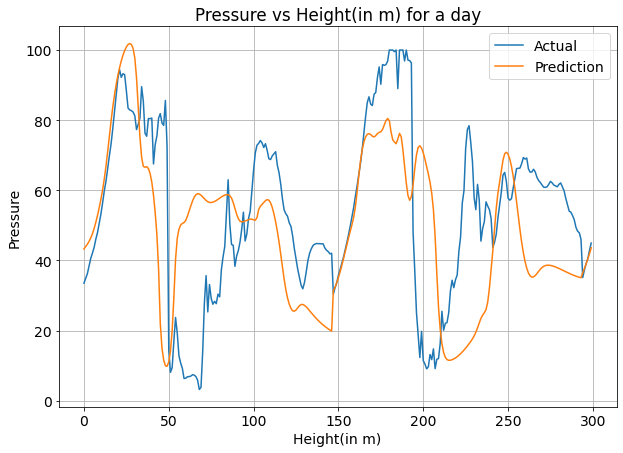

(4258, 1)


In [ ]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

def percentage_error(actual,pred):
  p_list = []
  for i in range(len(actual)):
    temp = (abs(actual[i]-pred[i]))/actual[i]
    p_list.append(temp)
  return sum(p_list)/len(p_list)

# total predictions
t=x_test
t=np.reshape(t, (len(t),len(t[0]), 1))
y_pred = model.predict(t)
y_pred.shape

# single prediction
a=x_test[1,:]
t=a
t=np.reshape(t, (1,len(x_test[0]), 1))
model.predict(t)
print(y_pred[:,0])
print(y_test[:,2])
  

# linear_mae = mean_absolute_error(y_test[:,2], y_pred[:,0])
# print(linear_mae)  
print(percentage_error(y_test[:,2], y_pred[:,0]))
plt.figure(figsize=(10,7))
plt.title("Pressure vs Height(in m) for a day")
plt.xlabel("Height(in m)")
plt.ylabel("Pressure")

plt.plot(y_test[:300,2])
plt.plot(y_pred[:300,0])
plt.legend(['Actual','Prediction'])
plt.grid()
plt.show()

print(y_pred.shape)


1/1 [==============================] - 0s 21ms/step
[72.46946   73.785484  74.904076  ...  9.2152405  9.60257   10.118138 ]
tf.Tensor([74.49 74.69 78.21 ... 13.17 12.9  12.6 ], shape=(9389,), dtype=float32)
tf.Tensor([0.17927836], shape=(1,), dtype=float32)


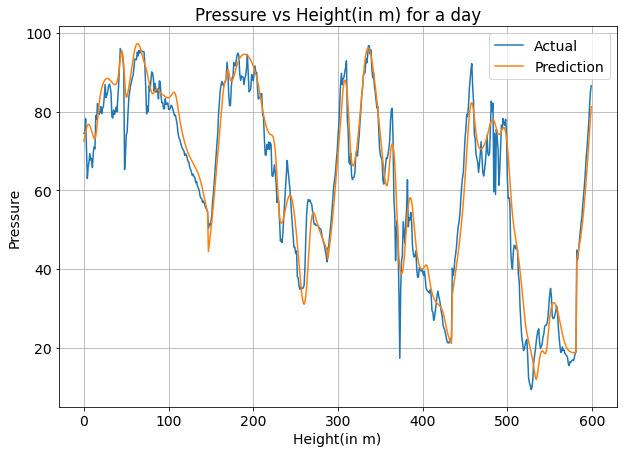

(9389, 1)


In [ ]:

def percentage_error(actual,pred):
  p_list = []
  for i in range(len(actual)):
    temp = (abs(actual[i]-pred[i]))/actual[i]
    p_list.append(temp)
  return sum(p_list)/len(p_list)

# total predictions
t=x_fit
t=np.reshape(t, (len(t),len(t[0]), 1))
y_pred = model.predict(t)
y_pred.shape

# single prediction
a=x_fit[1,:]
t=a
t=np.reshape(t, (1,len(x_test[0]), 1))
model.predict(t)

print(y_pred[:,0])
print(y_fit[:,0])
  
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

# linear_mae = mean_absolute_error(y_fit[:,2], y_pred[:,0])
# print(linear_mae)  
print(percentage_error(y_fit[:], y_pred[:,0]))
plt.figure(figsize=(10,7))
plt.title("Pressure vs Height(in m) for a day")
plt.xlabel("Height(in m)")
plt.ylabel("Pressure")

plt.plot(y_fit[:600])
plt.plot(y_pred[:600,0])
plt.legend(['Actual','Prediction'])
plt.grid()
plt.show()

print(y_pred.shape)


In [ ]:
plt.figure(figsize=(10,7))
plt.plot(y_test[:500,2])
plt.grid()
plt.xlabel("Index")
plt.ylabel("Relative Humidity")

plt.savefig('RH_graph.png', bbox_inches='tight')
plt.show()

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(y_test[:147,0])
plt.grid()
plt.xlabel("Height")
plt.ylabel("Pressure")

plt.savefig('Pressure_graph.png', bbox_inches='tight')
plt.show()

In [ ]:
#saving
import pickle
model.save('abc')
pickle.dump(model,open('saved_model_pressure.pkl','wb'))

#import
#lmodel = pickle.load(open('saved_model_pressure.pkl','rb'))

TypeError: ignored

In [ ]:
t=x_test_vband
print(np.shape(t))
t=np.reshape(t, (len(x_test),15, 1))
y_pred = model.predict(t)
y_pred.shape

# New

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [ ]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):


    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    # x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)

    for dim in mlp_units:
        x = tfa.activations.mish(x)
        x = layers.Dropout(mlp_dropout)(x)
    x=Flatten()(x)
    outputs = layers.Dense(1)(x)

    return keras.Model(inputs, outputs)

In [ ]:
input_shape = 23,1
print(input_shape)
model = build_model(
    input_shape,
    head_size=256,
    num_heads=12,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4)
)
model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, \
    restore_best_weights=True)]


(23, 1)
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 23, 1)]      0           []                               
                                                                                                  
 layer_normalization_56 (LayerN  (None, 23, 1)       2           ['input_9[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_28 (Multi  (None, 23, 1)       21505       ['layer_normalization_56[0][0]', 
 HeadAttention)                                                   'layer_normalization_56[0][0]'] 
                                                                                    

In [ ]:
model.fit(
    x_fit,
    y_fit,
    validation_split=0.2,
    epochs=50,
    batch_size=300,
)

Epoch 1/50
26/26 [==============================] - 16s 159ms/step - loss: 233358.0469 - val_loss: 150980.7344
Epoch 2/50
26/26 [==============================] - 4s 142ms/step - loss: 225983.5938 - val_loss: 141722.1562
Epoch 3/50
26/26 [==============================] - 4s 143ms/step - loss: 217655.6562 - val_loss: 132538.2188
Epoch 4/50
26/26 [==============================] - 4s 145ms/step - loss: 206508.8906 - val_loss: 123641.9062
Epoch 5/50
26/26 [==============================] - 4s 146ms/step - loss: 193841.0938 - val_loss: 114980.3828
Epoch 6/50
26/26 [==============================] - 4s 145ms/step - loss: 184389.6094 - val_loss: 106471.3438
Epoch 7/50
26/26 [==============================] - 4s 158ms/step - loss: 170935.7031 - val_loss: 98594.4297
Epoch 8/50
26/26 [==============================] - 4s 145ms/step - loss: 163154.5781 - val_loss: 90984.0312
Epoch 9/50
26/26 [==============================] - 4s 143ms/step - loss: 153877.2031 - val_loss: 83865.3125
Epoch 10/50


# New Timepass


In [ ]:
from numpy import nan
from numpy import isnan
from pandas import read_csv
from pandas import to_numeric
 
# fill missing values with a value at the same time one day ago
def fill_missing(values):
 one_day = 60 * 24
 for row in range(values.shape[0]):
  for col in range(values.shape[1]):
    if isnan(values[row, col]):
      values[row, col] = values[row - one_day, col]
 
# load all data
dataset = read_csv('household_power_consumption.txt', sep=';', header=0, low_memory=False, infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col=['datetime'])
# mark all missing values
dataset.replace('?', nan, inplace=True)
# make dataset numeric
dataset = dataset.astype('float32')
# fill missing
fill_missing(dataset.values)
# add a column for for the remainder of sub metering
values = dataset.values
dataset['sub_metering_4'] = (values[:,0] * 1000 / 60) - (values[:,4] + values[:,5] + values[:,6])
# save updated dataset
dataset.to_csv('household_power_consumption.csv')

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import glob
!pip install keras-tuner --upgrade --quiet
#from CNN import CNN
from Transformer import Transformer

from utils import series_to_supervised


In [ ]:
dataset = pd.read_csv('household_power_consumption.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])

In [ ]:
# resample data to daily
daily_groups = dataset.resample('D')
daily_data = daily_groups.sum()

# We choose to keep only Global_active_power
to_drop = ['Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3', 'sub_metering_4']
daily_data.drop(columns=to_drop, inplace=True)

# add calendar-related features
daily_data['day'] = pd.DatetimeIndex(daily_data.index).day
daily_data['weekday'] = ((pd.DatetimeIndex(daily_data.index).dayofweek) // 5 == 1).astype(float)
daily_data['season'] = [month%12 // 3 + 1 for month in pd.DatetimeIndex(daily_data.index).month]

# summarize
print(daily_data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 352 entries, 2006-12-16 to 2007-12-02
Freq: D
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Global_active_power  352 non-null    float64
 1   day                  352 non-null    int64  
 2   weekday              352 non-null    float64
 3   season               352 non-null    int64  
dtypes: float64(2), int64(2)
memory usage: 13.8 KB
None


In [ ]:

look_back = 7
n_features = daily_data.shape[1]

# Walk-forward data split to avoid data leakage
X_train, y_train, X_test, y_test, scale_X = series_to_supervised(daily_data, train_size=0.8, n_in=look_back, n_out=7, target_column='Global_active_power', dropnan=True, scale_X=True)

# reshape input to be 3D [samples, timesteps, features]
X_train_reshaped = X_train.values.reshape((-1,look_back,n_features))
X_test_reshaped = X_test.values.reshape((-1,look_back,n_features))

y_train_reshaped = y_train.values
y_test_reshaped = y_test.values

In [ ]:
## Testing the Transformer
tr = Transformer()
tr.train(X_train_reshaped,y_train_reshaped)
_, rmse_result, mae_result, smape_result, r2_result = tr.evaluate(X_test_reshaped,y_test_reshaped)


print('Result \n RMSE = %.2f [kWh] \n MAE = %.2f [kWh]\n R2 = %.1f [%%]' % (rmse_result,
                                                                            mae_result,
                                                                            r2_result*100))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 7, 4)]       0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 7, 4)        8           ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 7, 4)        19460       ['layer_normalization[0][0]',    
 dAttention)                                                      'layer_normalization[0][0]']    
                                                                                              


Epoch 1: loss improved from inf to 1151262.75000, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 21s 74ms/step - loss: 1151262.7500 - rmse: 1094.5461 - mae: 449.3511 - smape: 99.9984 - coeff_determination: -0.2215
Epoch 2/200
4/5 [=======================>......] - ETA: 0s - loss: 1118362.7500 - rmse: 1056.7454 - mae: 435.4991 - smape: 99.9977 - coeff_determination: -0.2047


Epoch 2: loss improved from 1151262.75000 to 1151233.12500, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 58ms/step - loss: 1151233.1250 - rmse: 1107.1001 - mae: 449.3559 - smape: 99.9976 - coeff_determination: -0.2394
Epoch 3/200
4/5 [=======================>......] - ETA: 0s - loss: 1163584.5000 - rmse: 1067.0029 - mae: 451.7144 - smape: 99.9977 - coeff_determination: -0.2178


Epoch 3: loss did not improve from 1151233.12500
5/5 [==============================] - 0s 20ms/step - loss: 1151243.1250 - rmse: 1047.5730 - mae: 449.3665 - smape: 99.9977 - coeff_determination: -0.2175
Epoch 4/200
4/5 [=======================>......] - ETA: 0s - loss: 1177011.5000 - rmse: 1082.7288 - mae: 459.5031 - smape: 99.9974 - coeff_determination: -0.2195


Epoch 4: loss improved from 1151233.12500 to 1151218.87500, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 59ms/step - loss: 1151218.8750 - rmse: 1034.8275 - mae: 449.3703 - smape: 99.9975 - coeff_determination: -0.1996
Epoch 5/200
4/5 [=======================>......] - ETA: 0s - loss: 1172757.5000 - rmse: 1082.4252 - mae: 455.6173 - smape: 99.9968 - coeff_determination: -0.2157


Epoch 5: loss improved from 1151218.87500 to 1151211.12500, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 61ms/step - loss: 1151211.1250 - rmse: 1042.9695 - mae: 449.3724 - smape: 99.9968 - coeff_determination: -0.2078
Epoch 6/200
4/5 [=======================>......] - ETA: 0s - loss: 1074032.6250 - rmse: 1032.8832 - mae: 421.1003 - smape: 99.9967 - coeff_determination: -0.1987


Epoch 6: loss improved from 1151211.12500 to 1151180.12500, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 57ms/step - loss: 1151180.1250 - rmse: 1140.4932 - mae: 449.3835 - smape: 99.9964 - coeff_determination: -0.2676
Epoch 7/200
4/5 [=======================>......] - ETA: 0s - loss: 1193124.2500 - rmse: 1089.5297 - mae: 463.7543 - smape: 99.9957 - coeff_determination: -0.2207


Epoch 7: loss improved from 1151180.12500 to 1151147.75000, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 58ms/step - loss: 1151147.7500 - rmse: 1003.4949 - mae: 449.4013 - smape: 99.9958 - coeff_determination: -0.1977
Epoch 8/200
4/5 [=======================>......] - ETA: 0s - loss: 1211679.1250 - rmse: 1096.1122 - mae: 472.9772 - smape: 99.9949 - coeff_determination: -0.2278


Epoch 8: loss improved from 1151147.75000 to 1151140.25000, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 59ms/step - loss: 1151140.2500 - rmse: 945.5753 - mae: 449.4287 - smape: 99.9951 - coeff_determination: -0.1861
Epoch 9/200
4/5 [=======================>......] - ETA: 0s - loss: 1120349.2500 - rmse: 1057.7218 - mae: 437.5409 - smape: 99.9943 - coeff_determination: -0.2062


Epoch 9: loss improved from 1151140.25000 to 1151106.87500, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 65ms/step - loss: 1151106.8750 - rmse: 1105.1010 - mae: 449.4479 - smape: 99.9941 - coeff_determination: -0.2329
Epoch 10/200
4/5 [=======================>......] - ETA: 0s - loss: 1202413.2500 - rmse: 1085.7729 - mae: 466.0733 - smape: 99.9936 - coeff_determination: -0.2231


Epoch 10: loss improved from 1151106.87500 to 1151048.00000, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 60ms/step - loss: 1151048.0000 - rmse: 973.3874 - mae: 449.4727 - smape: 99.9937 - coeff_determination: -0.2007
Epoch 11/200
4/5 [=======================>......] - ETA: 0s - loss: 1155783.5000 - rmse: 1066.2142 - mae: 452.1918 - smape: 99.9922 - coeff_determination: -0.2185


Epoch 11: loss improved from 1151048.00000 to 1150990.50000, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 62ms/step - loss: 1150990.5000 - rmse: 1059.7747 - mae: 449.5253 - smape: 99.9923 - coeff_determination: -0.2108
Epoch 12/200
4/5 [=======================>......] - ETA: 0s - loss: 1132057.3750 - rmse: 1060.7990 - mae: 443.3663 - smape: 99.9906 - coeff_determination: -0.2108


Epoch 12: loss improved from 1150990.50000 to 1150886.62500, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 61ms/step - loss: 1150886.6250 - rmse: 1091.3109 - mae: 449.5582 - smape: 99.9902 - coeff_determination: -0.2214
Epoch 13/200
4/5 [=======================>......] - ETA: 0s - loss: 1188661.1250 - rmse: 1082.8884 - mae: 464.0914 - smape: 99.9887 - coeff_determination: -0.2238


Epoch 13: loss improved from 1150886.62500 to 1150854.62500, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 59ms/step - loss: 1150854.6250 - rmse: 1008.5250 - mae: 449.6505 - smape: 99.9890 - coeff_determination: -0.1966
Epoch 14/200
4/5 [=======================>......] - ETA: 0s - loss: 1154196.8750 - rmse: 1072.2793 - mae: 449.1929 - smape: 99.9864 - coeff_determination: -0.2113


Epoch 14: loss improved from 1150854.62500 to 1150741.00000, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 59ms/step - loss: 1150741.0000 - rmse: 1066.7982 - mae: 449.6843 - smape: 99.9862 - coeff_determination: -0.2163
Epoch 15/200
4/5 [=======================>......] - ETA: 0s - loss: 1117650.5000 - rmse: 1054.3715 - mae: 437.3603 - smape: 99.9851 - coeff_determination: -0.2059


Epoch 15: loss improved from 1150741.00000 to 1150664.00000, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 59ms/step - loss: 1150664.0000 - rmse: 1105.3441 - mae: 449.7813 - smape: 99.9843 - coeff_determination: -0.2330
Epoch 16/200
4/5 [=======================>......] - ETA: 0s - loss: 1184377.3750 - rmse: 1086.4863 - mae: 464.0391 - smape: 99.9810 - coeff_determination: -0.2216


Epoch 16: loss improved from 1150664.00000 to 1150517.00000, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 60ms/step - loss: 1150517.0000 - rmse: 1020.5342 - mae: 449.8436 - smape: 99.9814 - coeff_determination: -0.1932
Epoch 17/200
4/5 [=======================>......] - ETA: 0s - loss: 1149344.0000 - rmse: 1062.9199 - mae: 449.0615 - smape: 99.9800 - coeff_determination: -0.2138


Epoch 17: loss improved from 1150517.00000 to 1150480.00000, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 59ms/step - loss: 1150480.0000 - rmse: 1066.6566 - mae: 449.9610 - smape: 99.9803 - coeff_determination: -0.2161
Epoch 18/200
4/5 [=======================>......] - ETA: 0s - loss: 1179090.7500 - rmse: 1085.6453 - mae: 461.6718 - smape: 99.9763 - coeff_determination: -0.2200


Epoch 18: loss improved from 1150480.00000 to 1150284.37500, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 59ms/step - loss: 1150284.3750 - rmse: 1030.8317 - mae: 450.0419 - smape: 99.9761 - coeff_determination: -0.1969
Epoch 19/200
4/5 [=======================>......] - ETA: 0s - loss: 1201623.5000 - rmse: 1090.6516 - mae: 470.9981 - smape: 99.9719 - coeff_determination: -0.2276


Epoch 19: loss improved from 1150284.37500 to 1150040.50000, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 58ms/step - loss: 1150040.5000 - rmse: 976.3849 - mae: 450.0981 - smape: 99.9726 - coeff_determination: -0.1881
Epoch 20/200
4/5 [=======================>......] - ETA: 0s - loss: 1142005.0000 - rmse: 1067.6603 - mae: 447.4854 - smape: 99.9688 - coeff_determination: -0.2101


Epoch 20: loss improved from 1150040.50000 to 1149914.75000, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 60ms/step - loss: 1149914.7500 - rmse: 1080.8359 - mae: 450.2518 - smape: 99.9688 - coeff_determination: -0.2152
Epoch 21/200
4/5 [=======================>......] - ETA: 0s - loss: 1169214.8750 - rmse: 1081.2039 - mae: 456.9419 - smape: 99.9661 - coeff_determination: -0.2143


Epoch 21: loss improved from 1149914.75000 to 1149849.37500, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 57ms/step - loss: 1149849.3750 - rmse: 1045.9984 - mae: 450.4138 - smape: 99.9664 - coeff_determination: -0.2034
Epoch 22/200
4/5 [=======================>......] - ETA: 0s - loss: 1111434.6250 - rmse: 1049.8917 - mae: 434.6292 - smape: 99.9620 - coeff_determination: -0.2022


Epoch 22: loss improved from 1149849.37500 to 1149552.00000, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 58ms/step - loss: 1149552.0000 - rmse: 1108.2482 - mae: 450.5106 - smape: 99.9605 - coeff_determination: -0.2423
Epoch 23/200
4/5 [=======================>......] - ETA: 0s - loss: 1081735.3750 - rmse: 1039.6829 - mae: 428.9765 - smape: 99.9630 - coeff_determination: -0.2012


Epoch 23: loss improved from 1149552.00000 to 1149505.25000, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 61ms/step - loss: 1149505.2500 - rmse: 1135.4641 - mae: 450.6816 - smape: 99.9602 - coeff_determination: -0.2428
Epoch 24/200
4/5 [=======================>......] - ETA: 0s - loss: 1151186.2500 - rmse: 1069.4523 - mae: 451.6024 - smape: 99.9522 - coeff_determination: -0.2122


Epoch 24: loss improved from 1149505.25000 to 1149179.37500, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 61ms/step - loss: 1149179.3750 - rmse: 1066.7422 - mae: 450.8164 - smape: 99.9530 - coeff_determination: -0.2105
Epoch 25/200
4/5 [=======================>......] - ETA: 0s - loss: 1149034.1250 - rmse: 1064.7972 - mae: 451.7296 - smape: 99.9495 - coeff_determination: -0.2130


Epoch 25: loss improved from 1149179.37500 to 1148956.25000, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 57ms/step - loss: 1148956.2500 - rmse: 1066.0924 - mae: 450.9960 - smape: 99.9490 - coeff_determination: -0.2095
Epoch 26/200
4/5 [=======================>......] - ETA: 0s - loss: 1184225.2500 - rmse: 1082.8810 - mae: 464.1799 - smape: 99.9439 - coeff_determination: -0.2190


Epoch 26: loss improved from 1148956.25000 to 1148859.75000, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 59ms/step - loss: 1148859.7500 - rmse: 1013.9922 - mae: 451.1719 - smape: 99.9451 - coeff_determination: -0.1954
Epoch 27/200
4/5 [=======================>......] - ETA: 0s - loss: 1131545.1250 - rmse: 1058.9800 - mae: 447.2881 - smape: 99.9378 - coeff_determination: -0.2114


Epoch 27: loss improved from 1148859.75000 to 1148566.62500, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 57ms/step - loss: 1148566.6250 - rmse: 1087.1063 - mae: 451.4289 - smape: 99.9384 - coeff_determination: -0.2146
Epoch 28/200
4/5 [=======================>......] - ETA: 0s - loss: 1102750.5000 - rmse: 1045.6869 - mae: 434.6802 - smape: 99.9308 - coeff_determination: -0.2012


Epoch 28: loss improved from 1148566.62500 to 1148117.50000, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 61ms/step - loss: 1148117.5000 - rmse: 1113.8494 - mae: 451.5706 - smape: 99.9284 - coeff_determination: -0.2391
Epoch 29/200
4/5 [=======================>......] - ETA: 0s - loss: 1135138.1250 - rmse: 1055.9836 - mae: 444.7876 - smape: 99.9244 - coeff_determination: -0.2068


Epoch 29: loss improved from 1148117.50000 to 1147710.75000, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 58ms/step - loss: 1147710.7500 - rmse: 1078.2206 - mae: 451.8367 - smape: 99.9222 - coeff_determination: -0.2269
Epoch 30/200
4/5 [=======================>......] - ETA: 0s - loss: 1143568.6250 - rmse: 1061.4209 - mae: 453.2629 - smape: 99.9123 - coeff_determination: -0.2156


Epoch 30: loss improved from 1147710.75000 to 1147421.12500, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 60ms/step - loss: 1147421.1250 - rmse: 1069.4248 - mae: 452.0342 - smape: 99.9135 - coeff_determination: -0.2071
Epoch 31/200
4/5 [=======================>......] - ETA: 0s - loss: 1178984.6250 - rmse: 1081.6934 - mae: 462.8145 - smape: 99.9106 - coeff_determination: -0.2145


Epoch 31: loss improved from 1147421.12500 to 1147175.50000, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 62ms/step - loss: 1147175.5000 - rmse: 1020.8283 - mae: 452.2608 - smape: 99.9108 - coeff_determination: -0.1973
Epoch 32/200
4/5 [=======================>......] - ETA: 0s - loss: 1146014.5000 - rmse: 1069.6973 - mae: 453.2130 - smape: 99.8991 - coeff_determination: -0.2090


Epoch 32: loss improved from 1147175.50000 to 1146677.87500, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 58ms/step - loss: 1146677.8750 - rmse: 1070.9785 - mae: 452.7189 - smape: 99.8988 - coeff_determination: -0.2063
Epoch 33/200
4/5 [=======================>......] - ETA: 0s - loss: 1186285.0000 - rmse: 1085.8163 - mae: 467.3130 - smape: 99.8931 - coeff_determination: -0.2168


Epoch 33: loss improved from 1146677.87500 to 1146528.12500, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 58ms/step - loss: 1146528.1250 - rmse: 1005.4758 - mae: 452.8896 - smape: 99.8960 - coeff_determination: -0.1914
Epoch 34/200
4/5 [=======================>......] - ETA: 0s - loss: 1157275.6250 - rmse: 1074.5387 - mae: 455.9365 - smape: 99.8834 - coeff_determination: -0.2081


Epoch 34: loss improved from 1146528.12500 to 1146007.50000, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 57ms/step - loss: 1146007.5000 - rmse: 1054.9459 - mae: 453.2773 - smape: 99.8829 - coeff_determination: -0.2065
Epoch 35/200
4/5 [=======================>......] - ETA: 0s - loss: 1147845.3750 - rmse: 1065.6917 - mae: 455.3333 - smape: 99.8777 - coeff_determination: -0.2114


Epoch 35: loss improved from 1146007.50000 to 1145737.37500, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 61ms/step - loss: 1145737.3750 - rmse: 1063.2437 - mae: 453.5612 - smape: 99.8789 - coeff_determination: -0.2053
Epoch 36/200
4/5 [=======================>......] - ETA: 0s - loss: 1140403.7500 - rmse: 1060.9600 - mae: 450.4342 - smape: 99.8752 - coeff_determination: -0.2063


Epoch 36: loss improved from 1145737.37500 to 1145564.50000, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 60ms/step - loss: 1145564.5000 - rmse: 1070.9067 - mae: 453.8782 - smape: 99.8747 - coeff_determination: -0.2162
Epoch 37/200
4/5 [=======================>......] - ETA: 0s - loss: 1129729.0000 - rmse: 1062.5439 - mae: 448.6680 - smape: 99.8570 - coeff_determination: -0.2030


Epoch 37: loss improved from 1145564.50000 to 1144777.62500, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 61ms/step - loss: 1144777.6250 - rmse: 1086.8141 - mae: 454.3673 - smape: 99.8556 - coeff_determination: -0.2148
Epoch 38/200
5/5 [==============================] - ETA: 0s - loss: 1143753.7500 - rmse: 1009.8128 - mae: 454.5258 - smape: 99.8377 - coeff_determination: -0.1929


Epoch 38: loss improved from 1144777.62500 to 1143753.75000, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 84ms/step - loss: 1143753.7500 - rmse: 1009.8128 - mae: 454.5258 - smape: 99.8377 - coeff_determination: -0.1929
Epoch 39/200
5/5 [==============================] - ETA: 0s - loss: 1143820.5000 - rmse: 1080.7258 - mae: 455.1514 - smape: 99.8368 - coeff_determination: -0.2147


Epoch 39: loss did not improve from 1143753.75000
5/5 [==============================] - 0s 34ms/step - loss: 1143820.5000 - rmse: 1080.7258 - mae: 455.1514 - smape: 99.8368 - coeff_determination: -0.2147
Epoch 40/200
3/5 [=================>............] - ETA: 0s - loss: 1162871.6250 - rmse: 1073.3429 - mae: 458.9216 - smape: 99.8244 - coeff_determination: -0.2049


Epoch 40: loss improved from 1143753.75000 to 1142896.37500, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 79ms/step - loss: 1142896.3750 - rmse: 1082.3711 - mae: 455.4313 - smape: 99.8213 - coeff_determination: -0.2143
Epoch 41/200
5/5 [==============================] - ETA: 0s - loss: 1142480.0000 - rmse: 1062.2634 - mae: 455.8884 - smape: 99.8129 - coeff_determination: -0.2229


Epoch 41: loss improved from 1142896.37500 to 1142480.00000, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 82ms/step - loss: 1142480.0000 - rmse: 1062.2634 - mae: 455.8884 - smape: 99.8129 - coeff_determination: -0.2229
Epoch 42/200
4/5 [=======================>......] - ETA: 0s - loss: 1152844.1250 - rmse: 1065.4523 - mae: 458.9720 - smape: 99.7912 - coeff_determination: -0.2063


Epoch 42: loss improved from 1142480.00000 to 1141329.87500, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 82ms/step - loss: 1141329.8750 - rmse: 1046.7655 - mae: 456.3174 - smape: 99.7895 - coeff_determination: -0.2040
Epoch 43/200
5/5 [==============================] - ETA: 0s - loss: 1140927.2500 - rmse: 1074.7484 - mae: 457.0924 - smape: 99.7734 - coeff_determination: -0.2060


Epoch 43: loss improved from 1141329.87500 to 1140927.25000, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 89ms/step - loss: 1140927.2500 - rmse: 1074.7484 - mae: 457.0924 - smape: 99.7734 - coeff_determination: -0.2060
Epoch 44/200
5/5 [==============================] - ETA: 0s - loss: 1140155.1250 - rmse: 1067.1399 - mae: 457.5773 - smape: 99.7622 - coeff_determination: -0.2132


Epoch 44: loss improved from 1140927.25000 to 1140155.12500, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 83ms/step - loss: 1140155.1250 - rmse: 1067.1399 - mae: 457.5773 - smape: 99.7622 - coeff_determination: -0.2132
Epoch 45/200
4/5 [=======================>......] - ETA: 0s - loss: 1127561.1250 - rmse: 1057.5883 - mae: 452.0034 - smape: 99.7491 - coeff_determination: -0.1968


Epoch 45: loss improved from 1140155.12500 to 1139021.00000, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 60ms/step - loss: 1139021.0000 - rmse: 1077.1205 - mae: 458.4286 - smape: 99.7417 - coeff_determination: -0.2141
Epoch 46/200
4/5 [=======================>......] - ETA: 0s - loss: 1047358.3750 - rmse: 1012.7776 - mae: 421.3968 - smape: 99.7529 - coeff_determination: -0.1790


Epoch 46: loss improved from 1139021.00000 to 1138297.62500, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 58ms/step - loss: 1138297.6250 - rmse: 1138.2664 - mae: 458.7746 - smape: 99.7205 - coeff_determination: -0.2969
Epoch 47/200
4/5 [=======================>......] - ETA: 0s - loss: 1181523.3750 - rmse: 1074.8362 - mae: 475.8809 - smape: 99.6848 - coeff_determination: -0.2099


Epoch 47: loss improved from 1138297.62500 to 1136681.37500, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 60ms/step - loss: 1136681.3750 - rmse: 981.7505 - mae: 459.5104 - smape: 99.6904 - coeff_determination: -0.1794
Epoch 48/200
4/5 [=======================>......] - ETA: 0s - loss: 1133523.1250 - rmse: 1061.2952 - mae: 458.2327 - smape: 99.6798 - coeff_determination: -0.1961


Epoch 48: loss improved from 1136681.37500 to 1136155.87500, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 60ms/step - loss: 1136155.8750 - rmse: 1066.3918 - mae: 460.4373 - smape: 99.6764 - coeff_determination: -0.2024
Epoch 49/200
3/5 [=================>............] - ETA: 0s - loss: 1060966.0000 - rmse: 1027.8800 - mae: 430.4877 - smape: 99.6976 - coeff_determination: -0.1794


Epoch 49: loss improved from 1136155.87500 to 1136010.12500, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 65ms/step - loss: 1136010.1250 - rmse: 1023.3889 - mae: 461.2082 - smape: 99.6700 - coeff_determination: -0.1864
Epoch 50/200
4/5 [=======================>......] - ETA: 0s - loss: 1128789.2500 - rmse: 1061.8513 - mae: 462.1632 - smape: 99.6283 - coeff_determination: -0.1964


Epoch 50: loss improved from 1136010.12500 to 1134268.25000, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 61ms/step - loss: 1134268.2500 - rmse: 1071.0912 - mae: 461.9453 - smape: 99.6333 - coeff_determination: -0.1921
Epoch 51/200
4/5 [=======================>......] - ETA: 0s - loss: 1097766.5000 - rmse: 1044.4590 - mae: 446.7689 - smape: 99.6395 - coeff_determination: -0.1858


Epoch 51: loss improved from 1134268.25000 to 1133970.87500, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 60ms/step - loss: 1133970.8750 - rmse: 1100.2830 - mae: 462.5005 - smape: 99.6279 - coeff_determination: -0.2262
Epoch 52/200
4/5 [=======================>......] - ETA: 0s - loss: 1136841.5000 - rmse: 1061.3656 - mae: 468.0669 - smape: 99.5778 - coeff_determination: -0.1975


Epoch 52: loss improved from 1133970.87500 to 1132118.37500, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 61ms/step - loss: 1132118.3750 - rmse: 1054.1790 - mae: 463.7242 - smape: 99.5872 - coeff_determination: -0.1841
Epoch 53/200
4/5 [=======================>......] - ETA: 0s - loss: 1103058.1250 - rmse: 1049.1538 - mae: 451.3907 - smape: 99.5636 - coeff_determination: -0.1824


Epoch 53: loss improved from 1132118.37500 to 1130190.87500, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 60ms/step - loss: 1130190.8750 - rmse: 1091.7716 - mae: 464.1446 - smape: 99.5485 - coeff_determination: -0.2178
Epoch 54/200
4/5 [=======================>......] - ETA: 0s - loss: 1068815.6250 - rmse: 1031.6830 - mae: 443.6214 - smape: 99.5563 - coeff_determination: -0.1801


Epoch 54: loss improved from 1130190.87500 to 1130068.62500, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 61ms/step - loss: 1130068.6250 - rmse: 1120.3347 - mae: 465.4017 - smape: 99.5408 - coeff_determination: -0.2289
Epoch 55/200
4/5 [=======================>......] - ETA: 0s - loss: 1114851.1250 - rmse: 1054.8470 - mae: 464.4314 - smape: 99.4997 - coeff_determination: -0.1907


Epoch 55: loss improved from 1130068.62500 to 1128747.87500, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 58ms/step - loss: 1128747.8750 - rmse: 1077.6228 - mae: 466.4726 - smape: 99.5060 - coeff_determination: -0.1887
Epoch 56/200
4/5 [=======================>......] - ETA: 0s - loss: 1123682.8750 - rmse: 1057.2607 - mae: 462.7872 - smape: 99.4647 - coeff_determination: -0.1816


Epoch 56: loss improved from 1128747.87500 to 1126302.75000, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 60ms/step - loss: 1126302.7500 - rmse: 1062.2356 - mae: 467.8424 - smape: 99.4479 - coeff_determination: -0.2031
Epoch 57/200
4/5 [=======================>......] - ETA: 0s - loss: 1121023.7500 - rmse: 1052.9355 - mae: 465.4011 - smape: 99.4547 - coeff_determination: -0.1851


Epoch 57: loss improved from 1126302.75000 to 1125883.75000, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 58ms/step - loss: 1125883.7500 - rmse: 1062.2419 - mae: 468.7134 - smape: 99.4468 - coeff_determination: -0.1947
Epoch 58/200
4/5 [=======================>......] - ETA: 0s - loss: 1151042.1250 - rmse: 1067.3485 - mae: 479.4982 - smape: 99.4110 - coeff_determination: -0.1917


Epoch 58: loss improved from 1125883.75000 to 1124213.37500, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 60ms/step - loss: 1124213.3750 - rmse: 1017.1377 - mae: 470.0149 - smape: 99.4146 - coeff_determination: -0.1740
Epoch 59/200
4/5 [=======================>......] - ETA: 0s - loss: 1062903.8750 - rmse: 1023.8417 - mae: 449.9590 - smape: 99.3874 - coeff_determination: -0.1711


Epoch 59: loss improved from 1124213.37500 to 1121379.37500, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 58ms/step - loss: 1121379.3750 - rmse: 1110.2340 - mae: 471.1700 - smape: 99.3640 - coeff_determination: -0.2193
Epoch 60/200
4/5 [=======================>......] - ETA: 0s - loss: 1138410.2500 - rmse: 1062.7661 - mae: 478.1334 - smape: 99.3410 - coeff_determination: -0.1849


Epoch 60: loss improved from 1121379.37500 to 1120902.62500, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 62ms/step - loss: 1120902.6250 - rmse: 1031.5529 - mae: 472.7272 - smape: 99.3376 - coeff_determination: -0.1748
Epoch 61/200
4/5 [=======================>......] - ETA: 0s - loss: 1149786.7500 - rmse: 1067.5824 - mae: 483.9591 - smape: 99.2870 - coeff_determination: -0.1855


Epoch 61: loss improved from 1120902.62500 to 1119202.00000, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 59ms/step - loss: 1119202.0000 - rmse: 1008.6261 - mae: 473.9027 - smape: 99.2850 - coeff_determination: -0.1671
Epoch 62/200
4/5 [=======================>......] - ETA: 0s - loss: 1121085.0000 - rmse: 1057.3257 - mae: 478.5402 - smape: 99.2292 - coeff_determination: -0.1806


Epoch 62: loss improved from 1119202.00000 to 1116601.50000, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 60ms/step - loss: 1116601.5000 - rmse: 1049.8295 - mae: 474.9720 - smape: 99.2445 - coeff_determination: -0.1690
Epoch 63/200
4/5 [=======================>......] - ETA: 0s - loss: 1139499.7500 - rmse: 1063.3628 - mae: 484.9454 - smape: 99.1692 - coeff_determination: -0.1786


Epoch 63: loss improved from 1116601.50000 to 1113740.62500, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 60ms/step - loss: 1113740.6250 - rmse: 1014.8998 - mae: 476.4123 - smape: 99.1715 - coeff_determination: -0.1632
Epoch 64/200
4/5 [=======================>......] - ETA: 0s - loss: 1109906.3750 - rmse: 1048.9099 - mae: 475.7443 - smape: 99.1438 - coeff_determination: -0.1696


Epoch 64: loss improved from 1113740.62500 to 1110953.62500, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 61ms/step - loss: 1110953.6250 - rmse: 1051.6204 - mae: 477.9792 - smape: 99.1182 - coeff_determination: -0.1766
Epoch 65/200
4/5 [=======================>......] - ETA: 0s - loss: 1145852.7500 - rmse: 1068.6044 - mae: 495.9664 - smape: 99.0290 - coeff_determination: -0.1797


Epoch 65: loss improved from 1110953.62500 to 1109175.37500, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 60ms/step - loss: 1109175.3750 - rmse: 993.9108 - mae: 480.3593 - smape: 99.0637 - coeff_determination: -0.1485
Epoch 66/200
4/5 [=======================>......] - ETA: 0s - loss: 1125258.3750 - rmse: 1053.2207 - mae: 489.6190 - smape: 99.0333 - coeff_determination: -0.1757


Epoch 66: loss improved from 1109175.37500 to 1107918.87500, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 58ms/step - loss: 1107918.8750 - rmse: 1022.7977 - mae: 482.1830 - smape: 99.0513 - coeff_determination: -0.1609
Epoch 67/200
4/5 [=======================>......] - ETA: 0s - loss: 1098663.0000 - rmse: 1044.2460 - mae: 483.9237 - smape: 99.0019 - coeff_determination: -0.1667


Epoch 67: loss improved from 1107918.87500 to 1105524.75000, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 57ms/step - loss: 1105524.7500 - rmse: 1056.5422 - mae: 484.1586 - smape: 99.0135 - coeff_determination: -0.1628
Epoch 68/200
4/5 [=======================>......] - ETA: 0s - loss: 1109872.7500 - rmse: 1050.4679 - mae: 487.1613 - smape: 99.0004 - coeff_determination: -0.1664


Epoch 68: loss improved from 1105524.75000 to 1104894.75000, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 58ms/step - loss: 1104894.7500 - rmse: 1042.3582 - mae: 485.5456 - smape: 98.9934 - coeff_determination: -0.1611
Epoch 69/200
4/5 [=======================>......] - ETA: 0s - loss: 1123765.5000 - rmse: 1058.4076 - mae: 495.7991 - smape: 98.8920 - coeff_determination: -0.1670


Epoch 69: loss improved from 1104894.75000 to 1102450.62500, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 57ms/step - loss: 1102450.6250 - rmse: 1018.6188 - mae: 487.3307 - smape: 98.9145 - coeff_determination: -0.1493
Epoch 70/200
4/5 [=======================>......] - ETA: 0s - loss: 1101838.5000 - rmse: 1044.2930 - mae: 494.2469 - smape: 98.8064 - coeff_determination: -0.1647


Epoch 70: loss improved from 1102450.62500 to 1098937.12500, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 59ms/step - loss: 1098937.1250 - rmse: 1040.3168 - mae: 489.7298 - smape: 98.8440 - coeff_determination: -0.1516
Epoch 71/200
4/5 [=======================>......] - ETA: 0s - loss: 1116283.1250 - rmse: 1052.2308 - mae: 500.8122 - smape: 98.7589 - coeff_determination: -0.1627


Epoch 71: loss improved from 1098937.12500 to 1097128.62500, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 61ms/step - loss: 1097128.6250 - rmse: 1017.3097 - mae: 492.0506 - smape: 98.7893 - coeff_determination: -0.1441
Epoch 72/200
4/5 [=======================>......] - ETA: 0s - loss: 1094252.0000 - rmse: 1043.9369 - mae: 493.1518 - smape: 98.7412 - coeff_determination: -0.1564


Epoch 72: loss improved from 1097128.62500 to 1095488.62500, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 59ms/step - loss: 1095488.6250 - rmse: 1046.4875 - mae: 493.2867 - smape: 98.7366 - coeff_determination: -0.1532
Epoch 73/200
4/5 [=======================>......] - ETA: 0s - loss: 1070476.2500 - rmse: 1033.2358 - mae: 483.9258 - smape: 98.7350 - coeff_determination: -0.1420


Epoch 73: loss improved from 1095488.62500 to 1092079.75000, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 59ms/step - loss: 1092079.7500 - rmse: 1068.3141 - mae: 496.0685 - smape: 98.6603 - coeff_determination: -0.1790
Epoch 74/200
4/5 [=======================>......] - ETA: 0s - loss: 1043999.0000 - rmse: 1021.4015 - mae: 482.0584 - smape: 98.6454 - coeff_determination: -0.1393


Epoch 74: loss improved from 1092079.75000 to 1088823.37500, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 60ms/step - loss: 1088823.3750 - rmse: 1089.4316 - mae: 497.6166 - smape: 98.5960 - coeff_determination: -0.1722
Epoch 75/200
4/5 [=======================>......] - ETA: 0s - loss: 1032731.6875 - rmse: 1014.2646 - mae: 479.5504 - smape: 98.5883 - coeff_determination: -0.1373


Epoch 75: loss improved from 1088823.37500 to 1087164.12500, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 59ms/step - loss: 1087164.1250 - rmse: 1095.3937 - mae: 499.0710 - smape: 98.5358 - coeff_determination: -0.1778
Epoch 76/200
4/5 [=======================>......] - ETA: 0s - loss: 1101822.2500 - rmse: 1048.4556 - mae: 507.3226 - smape: 98.4149 - coeff_determination: -0.1405


Epoch 76: loss improved from 1087164.12500 to 1080197.25000, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 59ms/step - loss: 1080197.2500 - rmse: 1007.4214 - mae: 502.3795 - smape: 98.4075 - coeff_determination: -0.1351
Epoch 77/200
4/5 [=======================>......] - ETA: 0s - loss: 1093873.1250 - rmse: 1037.9432 - mae: 509.9795 - smape: 98.3387 - coeff_determination: -0.1385


Epoch 77: loss improved from 1080197.25000 to 1077144.12500, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 59ms/step - loss: 1077144.1250 - rmse: 1008.3024 - mae: 506.0921 - smape: 98.3224 - coeff_determination: -0.1303
Epoch 78/200
4/5 [=======================>......] - ETA: 0s - loss: 1071288.5000 - rmse: 1031.9249 - mae: 503.7084 - smape: 98.3565 - coeff_determination: -0.1350


Epoch 78: loss did not improve from 1077144.12500
5/5 [==============================] - 0s 20ms/step - loss: 1077978.3750 - rmse: 1043.9114 - mae: 506.1111 - smape: 98.3227 - coeff_determination: -0.1372
Epoch 79/200
4/5 [=======================>......] - ETA: 0s - loss: 1044479.7500 - rmse: 1014.2035 - mae: 499.9846 - smape: 98.2213 - coeff_determination: -0.1259


Epoch 79: loss improved from 1077144.12500 to 1072040.00000, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 59ms/step - loss: 1072040.0000 - rmse: 1059.7498 - mae: 510.5970 - smape: 98.1910 - coeff_determination: -0.1479
Epoch 80/200
4/5 [=======================>......] - ETA: 0s - loss: 1115622.1250 - rmse: 1042.6912 - mae: 530.3193 - smape: 98.0973 - coeff_determination: -0.1454


Epoch 80: loss improved from 1072040.00000 to 1070556.75000, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 59ms/step - loss: 1070556.7500 - rmse: 943.9601 - mae: 512.9431 - smape: 98.1536 - coeff_determination: -0.1164
Epoch 81/200
4/5 [=======================>......] - ETA: 0s - loss: 1052226.8750 - rmse: 1024.6157 - mae: 511.2799 - smape: 98.1278 - coeff_determination: -0.1259


Epoch 81: loss improved from 1070556.75000 to 1070025.25000, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 62ms/step - loss: 1070025.2500 - rmse: 1054.1096 - mae: 515.3591 - smape: 98.1286 - coeff_determination: -0.1305
Epoch 82/200
4/5 [=======================>......] - ETA: 0s - loss: 1075122.5000 - rmse: 1033.4595 - mae: 522.2582 - smape: 97.9818 - coeff_determination: -0.1279


Epoch 82: loss improved from 1070025.25000 to 1066409.87500, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 75ms/step - loss: 1066409.8750 - rmse: 1018.3625 - mae: 518.9909 - smape: 97.9955 - coeff_determination: -0.1173
Epoch 83/200
3/5 [=================>............] - ETA: 0s - loss: 1045891.3125 - rmse: 1022.2366 - mae: 516.1951 - smape: 97.9031 - coeff_determination: -0.1139


Epoch 83: loss improved from 1066409.87500 to 1056918.75000, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 79ms/step - loss: 1056918.7500 - rmse: 1041.3635 - mae: 519.9951 - smape: 97.8479 - coeff_determination: -0.1182
Epoch 84/200
4/5 [=======================>......] - ETA: 0s - loss: 1074610.5000 - rmse: 1025.1942 - mae: 528.7939 - smape: 97.8096 - coeff_determination: -0.1217


Epoch 84: loss did not improve from 1056918.75000
5/5 [==============================] - 0s 26ms/step - loss: 1058518.0000 - rmse: 997.2285 - mae: 523.1478 - smape: 97.8355 - coeff_determination: -0.1122
Epoch 85/200
4/5 [=======================>......] - ETA: 0s - loss: 1008369.0000 - rmse: 1001.4528 - mae: 513.5267 - smape: 97.7119 - coeff_determination: -0.1032


Epoch 85: loss improved from 1056918.75000 to 1052232.75000, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 82ms/step - loss: 1052232.7500 - rmse: 1069.5530 - mae: 526.7693 - smape: 97.6868 - coeff_determination: -0.1257
Epoch 86/200
3/5 [=================>............] - ETA: 0s - loss: 1075224.3750 - rmse: 1036.1772 - mae: 540.0732 - smape: 97.6334 - coeff_determination: -0.1185


Epoch 86: loss improved from 1052232.75000 to 1049902.12500, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 78ms/step - loss: 1049902.1250 - rmse: 1029.4822 - mae: 527.4102 - smape: 97.6958 - coeff_determination: -0.1043
Epoch 87/200
3/5 [=================>............] - ETA: 0s - loss: 1079145.3750 - rmse: 1038.2992 - mae: 547.1115 - smape: 97.3325 - coeff_determination: -0.1034


Epoch 87: loss improved from 1049902.12500 to 1040154.00000, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 80ms/step - loss: 1040154.0000 - rmse: 968.7288 - mae: 530.5269 - smape: 97.4503 - coeff_determination: -0.0811
Epoch 88/200
5/5 [==============================] - ETA: 0s - loss: 1041332.1875 - rmse: 1009.1774 - mae: 533.9986 - smape: 97.4311 - coeff_determination: -0.0870


Epoch 88: loss did not improve from 1040154.00000
5/5 [==============================] - 0s 36ms/step - loss: 1041332.1875 - rmse: 1009.1774 - mae: 533.9986 - smape: 97.4311 - coeff_determination: -0.0870
Epoch 89/200
4/5 [=======================>......] - ETA: 0s - loss: 1092731.6250 - rmse: 1036.9038 - mae: 553.6302 - smape: 97.2687 - coeff_determination: -0.1096


Epoch 89: loss did not improve from 1040154.00000
5/5 [==============================] - 0s 29ms/step - loss: 1040419.1875 - rmse: 906.3657 - mae: 534.6014 - smape: 97.3648 - coeff_determination: -0.0972
Epoch 90/200
5/5 [==============================] - ETA: 0s - loss: 1032535.3750 - rmse: 1001.6608 - mae: 538.3718 - smape: 97.2013 - coeff_determination: -0.0962


Epoch 90: loss improved from 1040154.00000 to 1032535.37500, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 88ms/step - loss: 1032535.3750 - rmse: 1001.6608 - mae: 538.3718 - smape: 97.2013 - coeff_determination: -0.0962
Epoch 91/200
4/5 [=======================>......] - ETA: 0s - loss: 1057684.6250 - rmse: 1027.9532 - mae: 553.6184 - smape: 97.0025 - coeff_determination: -0.0910


Epoch 91: loss improved from 1032535.37500 to 1028351.31250, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 59ms/step - loss: 1028351.3125 - rmse: 967.6525 - mae: 541.2163 - smape: 97.0930 - coeff_determination: -0.0743
Epoch 92/200
4/5 [=======================>......] - ETA: 0s - loss: 1013877.1250 - rmse: 1000.4406 - mae: 539.9698 - smape: 96.9842 - coeff_determination: -0.0779


Epoch 92: loss improved from 1028351.31250 to 1021851.50000, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 63ms/step - loss: 1021851.5000 - rmse: 1015.5685 - mae: 543.1896 - smape: 96.9882 - coeff_determination: -0.0837
Epoch 93/200
4/5 [=======================>......] - ETA: 0s - loss: 995788.7500 - rmse: 997.8768 - mae: 537.1935 - smape: 96.9931 - coeff_determination: -0.0714


Epoch 93: loss did not improve from 1021851.50000
5/5 [==============================] - 0s 20ms/step - loss: 1022383.3750 - rmse: 1041.3047 - mae: 547.8887 - smape: 96.9205 - coeff_determination: -0.0971
Epoch 94/200
4/5 [=======================>......] - ETA: 0s - loss: 1070245.1250 - rmse: 1032.3683 - mae: 568.0954 - smape: 96.8425 - coeff_determination: -0.0874


Epoch 94: loss did not improve from 1021851.50000
5/5 [==============================] - 0s 21ms/step - loss: 1023312.0625 - rmse: 920.1965 - mae: 552.1252 - smape: 96.9010 - coeff_determination: -0.0598
Epoch 95/200
4/5 [=======================>......] - ETA: 0s - loss: 1020463.6250 - rmse: 1010.0648 - mae: 558.0537 - smape: 96.6707 - coeff_determination: -0.0738


Epoch 95: loss improved from 1021851.50000 to 1017030.50000, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 60ms/step - loss: 1017030.5000 - rmse: 1003.8516 - mae: 554.8984 - smape: 96.7168 - coeff_determination: -0.0666
Epoch 96/200
4/5 [=======================>......] - ETA: 0s - loss: 1044101.3750 - rmse: 1017.9091 - mae: 567.3818 - smape: 96.5906 - coeff_determination: -0.0748


Epoch 96: loss improved from 1017030.50000 to 1014206.12500, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 61ms/step - loss: 1014206.1250 - rmse: 956.3123 - mae: 554.9724 - smape: 96.6870 - coeff_determination: -0.0675
Epoch 97/200
4/5 [=======================>......] - ETA: 0s - loss: 1015929.3750 - rmse: 1006.0685 - mae: 562.1847 - smape: 96.3761 - coeff_determination: -0.0582


Epoch 97: loss improved from 1014206.12500 to 1001638.62500, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 58ms/step - loss: 1001638.6250 - rmse: 978.9517 - mae: 555.8676 - smape: 96.4462 - coeff_determination: -0.0520
Epoch 98/200
4/5 [=======================>......] - ETA: 0s - loss: 975161.8750 - rmse: 984.5108 - mae: 549.4575 - smape: 96.5223 - coeff_determination: -0.0498


Epoch 98: loss improved from 1001638.62500 to 1000980.18750, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 58ms/step - loss: 1000980.1875 - rmse: 1027.7429 - mae: 559.7459 - smape: 96.3548 - coeff_determination: -0.0745
Epoch 99/200
4/5 [=======================>......] - ETA: 0s - loss: 1018251.0625 - rmse: 1005.7510 - mae: 573.7338 - smape: 96.1437 - coeff_determination: -0.0598


Epoch 99: loss improved from 1000980.18750 to 998304.93750, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 61ms/step - loss: 998304.9375 - rmse: 966.8218 - mae: 563.1780 - smape: 96.2955 - coeff_determination: -0.0435
Epoch 100/200
4/5 [=======================>......] - ETA: 0s - loss: 990275.8750 - rmse: 991.6855 - mae: 563.5474 - smape: 96.0175 - coeff_determination: -0.0423  


Epoch 100: loss improved from 998304.93750 to 986270.56250, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 60ms/step - loss: 986270.5625 - rmse: 984.9640 - mae: 560.9171 - smape: 96.0960 - coeff_determination: -0.0381
Epoch 101/200
4/5 [=======================>......] - ETA: 0s - loss: 1016984.3750 - rmse: 1006.5659 - mae: 577.1558 - smape: 96.0341 - coeff_determination: -0.0557


Epoch 101: loss did not improve from 986270.56250
5/5 [==============================] - 0s 21ms/step - loss: 996111.0000 - rmse: 965.2366 - mae: 570.2151 - smape: 96.1268 - coeff_determination: -0.0425
Epoch 102/200
4/5 [=======================>......] - ETA: 0s - loss: 997470.0625 - rmse: 993.0499 - mae: 575.9043 - smape: 95.7378 - coeff_determination: -0.0342


Epoch 102: loss improved from 986270.56250 to 975497.68750, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 59ms/step - loss: 975497.6875 - rmse: 949.4242 - mae: 568.4209 - smape: 95.8050 - coeff_determination: -0.0306
Epoch 103/200
4/5 [=======================>......] - ETA: 0s - loss: 1003088.5000 - rmse: 995.2001 - mae: 577.7043 - smape: 95.7577 - coeff_determination: -0.0406


Epoch 103: loss did not improve from 975497.68750
5/5 [==============================] - 0s 19ms/step - loss: 981621.6250 - rmse: 953.0363 - mae: 571.9088 - smape: 95.7943 - coeff_determination: -0.0362
Epoch 104/200
4/5 [=======================>......] - ETA: 0s - loss: 958073.6250 - rmse: 971.5876 - mae: 569.7456 - smape: 95.6595 - coeff_determination: -0.0233  


Epoch 104: loss improved from 975497.68750 to 971560.62500, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 63ms/step - loss: 971560.6250 - rmse: 996.5178 - mae: 572.9057 - smape: 95.6578 - coeff_determination: -0.0319
Epoch 105/200
4/5 [=======================>......] - ETA: 0s - loss: 946626.7500 - rmse: 967.2748 - mae: 565.6379 - smape: 95.4860 - coeff_determination: -0.0154  


Epoch 105: loss improved from 971560.62500 to 961765.50000, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 60ms/step - loss: 961765.5000 - rmse: 994.7391 - mae: 567.6331 - smape: 95.5528 - coeff_determination: -0.0154
Epoch 106/200
4/5 [=======================>......] - ETA: 0s - loss: 969038.8125 - rmse: 984.0198 - mae: 576.5568 - smape: 95.4371 - coeff_determination: -0.0148


Epoch 106: loss did not improve from 961765.50000
5/5 [==============================] - 0s 23ms/step - loss: 963601.9375 - rmse: 973.8505 - mae: 576.0961 - smape: 95.4273 - coeff_determination: -0.0188
Epoch 107/200
4/5 [=======================>......] - ETA: 0s - loss: 927364.5625 - rmse: 958.8207 - mae: 566.6108 - smape: 95.4913 - coeff_determination: -0.0050


Epoch 107: loss improved from 961765.50000 to 957367.18750, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 59ms/step - loss: 957367.1875 - rmse: 1009.4952 - mae: 579.5380 - smape: 95.3050 - coeff_determination: -0.0309
Epoch 108/200
4/5 [=======================>......] - ETA: 0s - loss: 1006599.1250 - rmse: 1002.3690 - mae: 599.7216 - smape: 95.2271 - coeff_determination: -0.0244


Epoch 108: loss did not improve from 957367.18750
5/5 [==============================] - 0s 21ms/step - loss: 965093.0000 - rmse: 903.2306 - mae: 585.4791 - smape: 95.3194 - coeff_determination: -0.0043
Epoch 109/200
4/5 [=======================>......] - ETA: 0s - loss: 921199.3125 - rmse: 956.5660 - mae: 570.4575 - smape: 94.9977 - coeff_determination: 0.0094


Epoch 109: loss improved from 957367.18750 to 940145.62500, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 62ms/step - loss: 940145.6250 - rmse: 990.0634 - mae: 577.5215 - smape: 94.9037 - coeff_determination: 0.0013
Epoch 110/200
4/5 [=======================>......] - ETA: 0s - loss: 952506.7500 - rmse: 975.8092 - mae: 585.7650 - smape: 95.1250 - coeff_determination: -0.0029


Epoch 110: loss did not improve from 940145.62500
5/5 [==============================] - 0s 22ms/step - loss: 954152.8750 - rmse: 978.8641 - mae: 588.2265 - smape: 95.1001 - coeff_determination: -0.0105
Epoch 111/200
5/5 [==============================] - ETA: 0s - loss: 939520.4375 - rmse: 917.2739 - mae: 588.0406 - smape: 94.7993 - coeff_determination: -0.0094


Epoch 111: loss improved from 940145.62500 to 939520.43750, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 59ms/step - loss: 939520.4375 - rmse: 917.2739 - mae: 588.0406 - smape: 94.7993 - coeff_determination: -0.0094
Epoch 112/200
4/5 [=======================>......] - ETA: 0s - loss: 941345.0000 - rmse: 967.1378 - mae: 587.8566 - smape: 94.5650 - coeff_determination: 0.0173


Epoch 112: loss improved from 939520.43750 to 928748.62500, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 58ms/step - loss: 928748.6250 - rmse: 942.6802 - mae: 581.1672 - smape: 94.6591 - coeff_determination: 0.0272
Epoch 113/200
4/5 [=======================>......] - ETA: 0s - loss: 921907.9375 - rmse: 955.6078 - mae: 581.6044 - smape: 94.7933 - coeff_determination: 0.0165


Epoch 113: loss improved from 928748.62500 to 923363.62500, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 61ms/step - loss: 923363.6250 - rmse: 959.2381 - mae: 587.1236 - smape: 94.4451 - coeff_determination: 0.0286
Epoch 114/200
4/5 [=======================>......] - ETA: 0s - loss: 941932.5625 - rmse: 966.9828 - mae: 600.0690 - smape: 94.2502 - coeff_determination: 0.0140   


Epoch 114: loss did not improve from 923363.62500
5/5 [==============================] - 0s 21ms/step - loss: 924881.1250 - rmse: 932.8182 - mae: 592.3643 - smape: 94.4233 - coeff_determination: 0.0261
Epoch 115/200
4/5 [=======================>......] - ETA: 0s - loss: 919135.7500 - rmse: 951.9097 - mae: 593.6477 - smape: 94.3020 - coeff_determination: 0.0264


Epoch 115: loss improved from 923363.62500 to 919249.18750, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 59ms/step - loss: 919249.1875 - rmse: 953.4845 - mae: 593.2002 - smape: 94.3219 - coeff_determination: 0.0289
Epoch 116/200
4/5 [=======================>......] - ETA: 0s - loss: 892977.5000 - rmse: 943.7512 - mae: 583.2288 - smape: 94.2198 - coeff_determination: 0.0450


Epoch 116: loss improved from 919249.18750 to 907324.31250, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 58ms/step - loss: 907324.3125 - rmse: 969.6799 - mae: 589.5126 - smape: 94.1020 - coeff_determination: 0.0321
Epoch 117/200
4/5 [=======================>......] - ETA: 0s - loss: 908420.8125 - rmse: 950.1436 - mae: 588.1284 - smape: 94.1441 - coeff_determination: 0.0317 


Epoch 117: loss did not improve from 907324.31250
5/5 [==============================] - 0s 20ms/step - loss: 914085.8750 - rmse: 961.1888 - mae: 589.1078 - smape: 94.2140 - coeff_determination: 0.0286
Epoch 118/200
4/5 [=======================>......] - ETA: 0s - loss: 911105.0000 - rmse: 948.5978 - mae: 602.1852 - smape: 93.7463 - coeff_determination: 0.0436   


Epoch 118: loss improved from 907324.31250 to 904601.87500, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 63ms/step - loss: 904601.8750 - rmse: 937.0483 - mae: 598.2099 - smape: 93.9612 - coeff_determination: 0.0286
Epoch 119/200
4/5 [=======================>......] - ETA: 0s - loss: 934101.0000 - rmse: 960.7611 - mae: 604.3492 - smape: 93.7089 - coeff_determination: 0.0416  


Epoch 119: loss improved from 904601.87500 to 902569.56250, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 60ms/step - loss: 902569.5625 - rmse: 889.3455 - mae: 593.4318 - smape: 93.9260 - coeff_determination: -0.0046
Epoch 120/200
4/5 [=======================>......] - ETA: 0s - loss: 934465.7500 - rmse: 965.8731 - mae: 605.9023 - smape: 93.8835 - coeff_determination: 0.0426  


Epoch 120: loss did not improve from 902569.56250
5/5 [==============================] - 0s 21ms/step - loss: 906774.0000 - rmse: 904.4814 - mae: 597.6422 - smape: 93.9859 - coeff_determination: 0.0411
Epoch 121/200
4/5 [=======================>......] - ETA: 0s - loss: 900676.3750 - rmse: 941.4752 - mae: 601.7643 - smape: 93.7284 - coeff_determination: 0.0361  


Epoch 121: loss improved from 902569.56250 to 896186.25000, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 61ms/step - loss: 896186.2500 - rmse: 934.2388 - mae: 600.0047 - smape: 93.7045 - coeff_determination: 0.0507
Epoch 122/200
4/5 [=======================>......] - ETA: 0s - loss: 901007.1250 - rmse: 942.5285 - mae: 595.2191 - smape: 93.5524 - coeff_determination: 0.0569


Epoch 122: loss improved from 896186.25000 to 886169.75000, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 65ms/step - loss: 886169.7500 - rmse: 913.1385 - mae: 590.4926 - smape: 93.6084 - coeff_determination: 0.0613
Epoch 123/200
4/5 [=======================>......] - ETA: 0s - loss: 868057.3750 - rmse: 925.2788 - mae: 592.6143 - smape: 93.3134 - coeff_determination: 0.0800


Epoch 123: loss improved from 886169.75000 to 882627.75000, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 60ms/step - loss: 882627.7500 - rmse: 952.9479 - mae: 596.7479 - smape: 93.4487 - coeff_determination: 0.0532
Epoch 124/200
4/5 [=======================>......] - ETA: 0s - loss: 884118.1250 - rmse: 939.3288 - mae: 597.6301 - smape: 93.1125 - coeff_determination: 0.0723


Epoch 124: loss improved from 882627.75000 to 879368.00000, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 61ms/step - loss: 879368.0000 - rmse: 930.1581 - mae: 592.5764 - smape: 93.3437 - coeff_determination: 0.0510
Epoch 125/200
4/5 [=======================>......] - ETA: 0s - loss: 867968.5000 - rmse: 931.0886 - mae: 591.5609 - smape: 93.0676 - coeff_determination: 0.0818


Epoch 125: loss improved from 879368.00000 to 869552.31250, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 58ms/step - loss: 869552.3125 - rmse: 934.2469 - mae: 593.2589 - smape: 93.1525 - coeff_determination: 0.0719
Epoch 126/200
4/5 [=======================>......] - ETA: 0s - loss: 896633.8750 - rmse: 945.2017 - mae: 606.4166 - smape: 93.2040 - coeff_determination: 0.0670


Epoch 126: loss did not improve from 869552.31250
5/5 [==============================] - 0s 21ms/step - loss: 887471.7500 - rmse: 927.1707 - mae: 602.4099 - smape: 93.4178 - coeff_determination: 0.0432
Epoch 127/200
4/5 [=======================>......] - ETA: 0s - loss: 876755.2500 - rmse: 933.6066 - mae: 606.7125 - smape: 92.9367 - coeff_determination: 0.0766  


Epoch 127: loss did not improve from 869552.31250
5/5 [==============================] - 0s 22ms/step - loss: 875023.6250 - rmse: 930.7842 - mae: 605.4754 - smape: 93.0449 - coeff_determination: 0.0698
Epoch 128/200
4/5 [=======================>......] - ETA: 0s - loss: 892772.5000 - rmse: 944.5745 - mae: 612.6991 - smape: 93.0679 - coeff_determination: 0.0713


Epoch 128: loss did not improve from 869552.31250
5/5 [==============================] - 0s 23ms/step - loss: 875591.6875 - rmse: 908.2863 - mae: 606.0425 - smape: 93.1252 - coeff_determination: 0.0677
Epoch 129/200
4/5 [=======================>......] - ETA: 0s - loss: 847835.1250 - rmse: 917.1240 - mae: 595.4963 - smape: 92.5711 - coeff_determination: 0.1091  


Epoch 129: loss improved from 869552.31250 to 848079.25000, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 66ms/step - loss: 848079.2500 - rmse: 918.3334 - mae: 593.6162 - smape: 92.7186 - coeff_determination: 0.0940
Epoch 130/200
4/5 [=======================>......] - ETA: 0s - loss: 868000.3750 - rmse: 930.4266 - mae: 613.2887 - smape: 92.5342 - coeff_determination: 0.0903


Epoch 130: loss did not improve from 848079.25000
5/5 [==============================] - 0s 22ms/step - loss: 861169.1250 - rmse: 916.9197 - mae: 605.8727 - smape: 92.8550 - coeff_determination: 0.0729
Epoch 131/200
4/5 [=======================>......] - ETA: 0s - loss: 852306.1250 - rmse: 916.4541 - mae: 599.0189 - smape: 92.8581 - coeff_determination: 0.0893  


Epoch 131: loss improved from 848079.25000 to 847901.56250, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 61ms/step - loss: 847901.5625 - rmse: 908.9735 - mae: 599.9198 - smape: 92.6471 - coeff_determination: 0.1154
Epoch 132/200
4/5 [=======================>......] - ETA: 0s - loss: 858566.6250 - rmse: 925.8397 - mae: 601.9782 - smape: 92.8584 - coeff_determination: 0.0940


Epoch 132: loss did not improve from 847901.56250
5/5 [==============================] - 0s 24ms/step - loss: 855334.0625 - rmse: 919.5757 - mae: 600.2979 - smape: 92.8312 - coeff_determination: 0.0994
Epoch 133/200
4/5 [=======================>......] - ETA: 0s - loss: 854970.5000 - rmse: 919.5508 - mae: 602.4924 - smape: 92.4473 - coeff_determination: 0.1054  


Epoch 133: loss improved from 847901.56250 to 845482.75000, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 59ms/step - loss: 845482.7500 - rmse: 900.9959 - mae: 599.7651 - smape: 92.4570 - coeff_determination: 0.1057
Epoch 134/200
4/5 [=======================>......] - ETA: 0s - loss: 835574.1875 - rmse: 912.1467 - mae: 593.2111 - smape: 92.8112 - coeff_determination: 0.1081


Epoch 134: loss did not improve from 845482.75000
5/5 [==============================] - 0s 21ms/step - loss: 846818.9375 - rmse: 933.5536 - mae: 600.4117 - smape: 92.5204 - coeff_determination: 0.1048
Epoch 135/200
4/5 [=======================>......] - ETA: 0s - loss: 847166.5625 - rmse: 917.4018 - mae: 603.5593 - smape: 92.2208 - coeff_determination: 0.1249


Epoch 135: loss improved from 845482.75000 to 836810.18750, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 61ms/step - loss: 836810.1875 - rmse: 896.4098 - mae: 600.4301 - smape: 92.3282 - coeff_determination: 0.1001
Epoch 136/200
4/5 [=======================>......] - ETA: 0s - loss: 816944.6250 - rmse: 899.6212 - mae: 591.6143 - smape: 92.4311 - coeff_determination: 0.1118


Epoch 136: loss improved from 836810.18750 to 834790.87500, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 75ms/step - loss: 834790.8750 - rmse: 933.1792 - mae: 596.8340 - smape: 92.3217 - coeff_determination: 0.1046
Epoch 137/200
4/5 [=======================>......] - ETA: 0s - loss: 852360.1250 - rmse: 922.2732 - mae: 615.1050 - smape: 91.8391 - coeff_determination: 0.1249


Epoch 137: loss did not improve from 834790.87500
5/5 [==============================] - 0s 27ms/step - loss: 836699.8125 - rmse: 888.7397 - mae: 610.1538 - smape: 92.1048 - coeff_determination: 0.0307
Epoch 138/200
4/5 [=======================>......] - ETA: 0s - loss: 802218.6875 - rmse: 893.5164 - mae: 590.7609 - smape: 92.4356 - coeff_determination: 0.1163


Epoch 138: loss improved from 834790.87500 to 833180.43750, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 76ms/step - loss: 833180.4375 - rmse: 948.1879 - mae: 602.7767 - smape: 92.1087 - coeff_determination: 0.1064
Epoch 139/200
4/5 [=======================>......] - ETA: 0s - loss: 822920.0000 - rmse: 906.4329 - mae: 595.4832 - smape: 92.2721 - coeff_determination: 0.1238


Epoch 139: loss improved from 833180.43750 to 824653.31250, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 78ms/step - loss: 824653.3125 - rmse: 909.9959 - mae: 596.7354 - smape: 92.0496 - coeff_determination: 0.1379
Epoch 140/200
5/5 [==============================] - ETA: 0s - loss: 820031.1250 - rmse: 849.8563 - mae: 600.8070 - smape: 91.8440 - coeff_determination: 0.0764


Epoch 140: loss improved from 824653.31250 to 820031.12500, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 82ms/step - loss: 820031.1250 - rmse: 849.8563 - mae: 600.8070 - smape: 91.8440 - coeff_determination: 0.0764
Epoch 141/200
5/5 [==============================] - ETA: 0s - loss: 833625.7500 - rmse: 854.8241 - mae: 606.7121 - smape: 91.9252 - coeff_determination: 0.0485


Epoch 141: loss did not improve from 820031.12500
5/5 [==============================] - 0s 29ms/step - loss: 833625.7500 - rmse: 854.8241 - mae: 606.7121 - smape: 91.9252 - coeff_determination: 0.0485
Epoch 142/200
4/5 [=======================>......] - ETA: 0s - loss: 829240.5000 - rmse: 908.6149 - mae: 606.8107 - smape: 91.6458 - coeff_determination: 0.1286


Epoch 142: loss improved from 820031.12500 to 813876.93750, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 79ms/step - loss: 813876.9375 - rmse: 875.4412 - mae: 598.7228 - smape: 91.7383 - coeff_determination: 0.1478
Epoch 143/200
4/5 [=======================>......] - ETA: 0s - loss: 792707.1875 - rmse: 881.9645 - mae: 589.4865 - smape: 91.8275 - coeff_determination: 0.1548  


Epoch 143: loss did not improve from 813876.93750
5/5 [==============================] - 0s 29ms/step - loss: 817266.3125 - rmse: 927.9594 - mae: 597.6956 - smape: 91.8365 - coeff_determination: 0.1168
Epoch 144/200
4/5 [=======================>......] - ETA: 0s - loss: 807811.0000 - rmse: 894.5095 - mae: 598.3813 - smape: 91.3070 - coeff_determination: 0.1599


Epoch 144: loss improved from 813876.93750 to 805810.56250, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 88ms/step - loss: 805810.5625 - rmse: 891.2970 - mae: 598.6795 - smape: 91.3949 - coeff_determination: 0.1437
Epoch 145/200
5/5 [==============================] - ETA: 0s - loss: 826453.2500 - rmse: 909.8283 - mae: 604.1890 - smape: 91.7467 - coeff_determination: 0.1282


Epoch 145: loss did not improve from 805810.56250
5/5 [==============================] - 0s 29ms/step - loss: 826453.2500 - rmse: 909.8283 - mae: 604.1890 - smape: 91.7467 - coeff_determination: 0.1282
Epoch 146/200
4/5 [=======================>......] - ETA: 0s - loss: 826416.8750 - rmse: 907.2252 - mae: 601.7266 - smape: 91.7181 - coeff_determination: 0.1323


Epoch 146: loss did not improve from 805810.56250
5/5 [==============================] - 0s 20ms/step - loss: 818871.3750 - rmse: 891.9240 - mae: 598.0413 - smape: 91.8107 - coeff_determination: 0.1369
Epoch 147/200
4/5 [=======================>......] - ETA: 0s - loss: 847929.7500 - rmse: 920.0950 - mae: 617.2717 - smape: 91.6583 - coeff_determination: 0.1139


Epoch 147: loss did not improve from 805810.56250
5/5 [==============================] - 0s 20ms/step - loss: 841604.6875 - rmse: 907.3835 - mae: 611.9269 - smape: 91.7477 - coeff_determination: 0.1132
Epoch 148/200
4/5 [=======================>......] - ETA: 0s - loss: 790336.3750 - rmse: 886.4296 - mae: 597.1420 - smape: 91.1989 - coeff_determination: 0.1540


Epoch 148: loss did not improve from 805810.56250
5/5 [==============================] - 0s 20ms/step - loss: 809949.5000 - rmse: 923.1232 - mae: 603.9200 - smape: 91.3021 - coeff_determination: 0.1140
Epoch 149/200
4/5 [=======================>......] - ETA: 0s - loss: 837866.3750 - rmse: 914.3138 - mae: 615.5452 - smape: 91.3924 - coeff_determination: 0.1260


Epoch 149: loss did not improve from 805810.56250
5/5 [==============================] - 0s 19ms/step - loss: 819604.5000 - rmse: 873.9901 - mae: 607.4462 - smape: 91.7248 - coeff_determination: 0.0862
Epoch 150/200
4/5 [=======================>......] - ETA: 0s - loss: 800014.7500 - rmse: 887.0937 - mae: 592.5651 - smape: 91.5595 - coeff_determination: 0.1310


Epoch 150: loss improved from 805810.56250 to 798589.62500, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 63ms/step - loss: 798589.6250 - rmse: 885.6599 - mae: 594.5558 - smape: 91.2717 - coeff_determination: 0.1705
Epoch 151/200
4/5 [=======================>......] - ETA: 0s - loss: 830064.0000 - rmse: 908.7241 - mae: 606.1611 - smape: 91.3717 - coeff_determination: 0.1230


Epoch 151: loss did not improve from 798589.62500
5/5 [==============================] - 0s 22ms/step - loss: 819024.0625 - rmse: 885.8011 - mae: 603.9893 - smape: 91.5134 - coeff_determination: 0.1189
Epoch 152/200
4/5 [=======================>......] - ETA: 0s - loss: 818413.8125 - rmse: 903.6345 - mae: 603.7798 - smape: 91.9874 - coeff_determination: 0.1051


Epoch 152: loss did not improve from 798589.62500
5/5 [==============================] - 0s 21ms/step - loss: 822133.9375 - rmse: 911.1229 - mae: 605.3918 - smape: 91.5080 - coeff_determination: 0.1498
Epoch 153/200
4/5 [=======================>......] - ETA: 0s - loss: 778872.8125 - rmse: 880.3167 - mae: 592.9597 - smape: 91.0493 - coeff_determination: 0.1496


Epoch 153: loss did not improve from 798589.62500
5/5 [==============================] - 0s 22ms/step - loss: 808230.8125 - rmse: 933.1004 - mae: 603.4067 - smape: 91.0544 - coeff_determination: 0.1052
Epoch 154/200
4/5 [=======================>......] - ETA: 0s - loss: 816334.1250 - rmse: 900.3550 - mae: 607.1357 - smape: 91.3028 - coeff_determination: 0.1359


Epoch 154: loss did not improve from 798589.62500
5/5 [==============================] - 0s 21ms/step - loss: 822089.3750 - rmse: 912.1499 - mae: 608.7777 - smape: 91.3594 - coeff_determination: 0.1385
Epoch 155/200
4/5 [=======================>......] - ETA: 0s - loss: 814118.3750 - rmse: 902.2297 - mae: 609.0386 - smape: 90.7392 - coeff_determination: 0.1492


Epoch 155: loss did not improve from 798589.62500
5/5 [==============================] - 0s 22ms/step - loss: 805174.5000 - rmse: 883.3426 - mae: 603.2578 - smape: 91.0804 - coeff_determination: 0.1215
Epoch 156/200
4/5 [=======================>......] - ETA: 0s - loss: 757283.5625 - rmse: 869.3899 - mae: 585.3895 - smape: 91.1684 - coeff_determination: 0.1623


Epoch 156: loss improved from 798589.62500 to 795609.62500, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 62ms/step - loss: 795609.6250 - rmse: 936.3195 - mae: 597.8285 - smape: 91.1184 - coeff_determination: 0.1327
Epoch 157/200
4/5 [=======================>......] - ETA: 0s - loss: 773939.9375 - rmse: 878.4974 - mae: 585.2905 - smape: 91.2810 - coeff_determination: 0.1683


Epoch 157: loss did not improve from 795609.62500
5/5 [==============================] - 0s 26ms/step - loss: 799070.5625 - rmse: 924.4253 - mae: 595.0694 - smape: 91.0382 - coeff_determination: 0.1303
Epoch 158/200
4/5 [=======================>......] - ETA: 0s - loss: 798259.1875 - rmse: 893.0717 - mae: 596.1981 - smape: 90.8779 - coeff_determination: 0.1434


Epoch 158: loss did not improve from 795609.62500
5/5 [==============================] - 0s 22ms/step - loss: 803162.4375 - rmse: 902.8021 - mae: 599.9099 - smape: 90.7738 - coeff_determination: 0.1639
Epoch 159/200
4/5 [=======================>......] - ETA: 0s - loss: 811447.1250 - rmse: 896.8138 - mae: 604.3702 - smape: 90.9353 - coeff_determination: 0.1561  


Epoch 159: loss did not improve from 795609.62500
5/5 [==============================] - 0s 20ms/step - loss: 797728.5625 - rmse: 867.5975 - mae: 600.0059 - smape: 90.9999 - coeff_determination: 0.1648
Epoch 160/200
4/5 [=======================>......] - ETA: 0s - loss: 810161.1875 - rmse: 895.8764 - mae: 599.6653 - smape: 90.5746 - coeff_determination: 0.1592


Epoch 160: loss did not improve from 795609.62500
5/5 [==============================] - 0s 21ms/step - loss: 797614.6250 - rmse: 869.4738 - mae: 595.3471 - smape: 90.9346 - coeff_determination: 0.0654
Epoch 161/200
4/5 [=======================>......] - ETA: 0s - loss: 800147.0000 - rmse: 888.1575 - mae: 595.3313 - smape: 90.7069 - coeff_determination: 0.1464


Epoch 161: loss did not improve from 795609.62500
5/5 [==============================] - 0s 21ms/step - loss: 803777.5000 - rmse: 896.6160 - mae: 598.5225 - smape: 90.8326 - coeff_determination: 0.1111
Epoch 162/200
4/5 [=======================>......] - ETA: 0s - loss: 811814.5000 - rmse: 897.1426 - mae: 598.5415 - smape: 90.7379 - coeff_determination: 0.1615


Epoch 162: loss improved from 795609.62500 to 785903.81250, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 59ms/step - loss: 785903.8125 - rmse: 834.9651 - mae: 586.6964 - smape: 90.9887 - coeff_determination: 0.1736
Epoch 163/200
4/5 [=======================>......] - ETA: 0s - loss: 779857.4375 - rmse: 880.5652 - mae: 589.3140 - smape: 90.7064 - coeff_determination: 0.1780


Epoch 163: loss improved from 785903.81250 to 784624.18750, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 62ms/step - loss: 784624.1875 - rmse: 890.5679 - mae: 592.3002 - smape: 90.8623 - coeff_determination: 0.1293
Epoch 164/200
4/5 [=======================>......] - ETA: 0s - loss: 790727.4375 - rmse: 883.7852 - mae: 598.5331 - smape: 90.6603 - coeff_determination: 0.1136 


Epoch 164: loss did not improve from 784624.18750
5/5 [==============================] - 0s 22ms/step - loss: 789596.9375 - rmse: 882.5620 - mae: 597.4897 - smape: 90.8800 - coeff_determination: 0.1194
Epoch 165/200
4/5 [=======================>......] - ETA: 0s - loss: 775932.5625 - rmse: 879.7303 - mae: 583.8778 - smape: 90.9202 - coeff_determination: 0.1673


Epoch 165: loss did not improve from 784624.18750
5/5 [==============================] - 0s 20ms/step - loss: 793702.9375 - rmse: 913.2584 - mae: 592.4396 - smape: 90.7605 - coeff_determination: 0.1459
Epoch 166/200
4/5 [=======================>......] - ETA: 0s - loss: 790720.9375 - rmse: 886.4783 - mae: 599.7339 - smape: 90.8191 - coeff_determination: 0.1630


Epoch 166: loss did not improve from 784624.18750
5/5 [==============================] - 0s 21ms/step - loss: 795944.6250 - rmse: 897.3417 - mae: 600.5289 - smape: 90.8355 - coeff_determination: 0.1430
Epoch 167/200
4/5 [=======================>......] - ETA: 0s - loss: 806051.9375 - rmse: 894.9344 - mae: 588.2582 - smape: 91.1231 - coeff_determination: 0.1558


Epoch 167: loss did not improve from 784624.18750
5/5 [==============================] - 0s 21ms/step - loss: 794841.3125 - rmse: 871.3198 - mae: 586.6881 - smape: 91.0221 - coeff_determination: 0.1602
Epoch 168/200
4/5 [=======================>......] - ETA: 0s - loss: 809795.0000 - rmse: 896.5375 - mae: 599.3243 - smape: 90.7512 - coeff_determination: 0.1605  


Epoch 168: loss did not improve from 784624.18750
5/5 [==============================] - 0s 21ms/step - loss: 795885.1250 - rmse: 866.6943 - mae: 591.9238 - smape: 90.9569 - coeff_determination: 0.1455
Epoch 169/200
4/5 [=======================>......] - ETA: 0s - loss: 812598.4375 - rmse: 899.3374 - mae: 591.8095 - smape: 90.4449 - coeff_determination: 0.1710


Epoch 169: loss did not improve from 784624.18750
5/5 [==============================] - 0s 21ms/step - loss: 793274.8125 - rmse: 855.6294 - mae: 584.0959 - smape: 90.9205 - coeff_determination: -0.0306
Epoch 170/200
4/5 [=======================>......] - ETA: 0s - loss: 801330.6250 - rmse: 892.5049 - mae: 595.4084 - smape: 90.4704 - coeff_determination: 0.1567


Epoch 170: loss improved from 784624.18750 to 783508.87500, saving model to checkpoint/Transformer.best20032023_08:09:13.hdf5
5/5 [==============================] - 0s 63ms/step - loss: 783508.8750 - rmse: 852.4743 - mae: 586.4271 - smape: 90.6589 - coeff_determination: 0.1693
Epoch 171/200
4/5 [=======================>......] - ETA: 0s - loss: 761674.5000 - rmse: 871.6587 - mae: 579.6503 - smape: 90.7731 - coeff_determination: 0.1687


Epoch 171: loss did not improve from 783508.87500
5/5 [==============================] - 0s 22ms/step - loss: 801277.7500 - rmse: 940.4050 - mae: 595.6978 - smape: 90.7698 - coeff_determination: 0.1093
Epoch 172/200
4/5 [=======================>......] - ETA: 0s - loss: 799836.3750 - rmse: 891.3279 - mae: 590.7075 - smape: 90.8051 - coeff_determination: 0.1267


Epoch 172: loss did not improve from 783508.87500
5/5 [==============================] - 0s 22ms/step - loss: 808483.8125 - rmse: 908.6198 - mae: 594.8018 - smape: 90.9176 - coeff_determination: 0.1282
Epoch 173/200
4/5 [=======================>......] - ETA: 0s - loss: 818047.1250 - rmse: 897.2919 - mae: 595.1715 - smape: 91.1887 - coeff_determination: 0.1438


Epoch 173: loss did not improve from 783508.87500
5/5 [==============================] - 0s 21ms/step - loss: 811088.6250 - rmse: 884.2463 - mae: 594.2920 - smape: 91.0260 - coeff_determination: 0.1596
Epoch 174/200
4/5 [=======================>......] - ETA: 0s - loss: 803591.2500 - rmse: 892.4679 - mae: 590.4857 - smape: 90.7851 - coeff_determination: 0.1502


Epoch 174: loss did not improve from 783508.87500
5/5 [==============================] - 0s 24ms/step - loss: 790991.2500 - rmse: 865.7572 - mae: 586.9814 - smape: 91.0003 - coeff_determination: 0.1288
Epoch 175/200
4/5 [=======================>......] - ETA: 0s - loss: 791599.8750 - rmse: 887.6816 - mae: 581.8621 - smape: 90.9737 - coeff_determination: 0.1525


Epoch 175: loss did not improve from 783508.87500
5/5 [==============================] - 0s 21ms/step - loss: 795135.8750 - rmse: 895.1301 - mae: 583.8657 - smape: 90.9297 - coeff_determination: 0.1519
Epoch 176/200
4/5 [=======================>......] - ETA: 0s - loss: 812885.1875 - rmse: 900.0632 - mae: 592.8064 - smape: 91.5131 - coeff_determination: 0.1293


Epoch 176: loss did not improve from 783508.87500
5/5 [==============================] - 0s 21ms/step - loss: 820415.3125 - rmse: 914.8765 - mae: 599.3282 - smape: 91.2848 - coeff_determination: 0.0992
Epoch 177/200
4/5 [=======================>......] - ETA: 0s - loss: 818104.0000 - rmse: 898.5136 - mae: 591.2734 - smape: 91.6467 - coeff_determination: 0.1333


Epoch 177: loss did not improve from 783508.87500
5/5 [==============================] - 0s 20ms/step - loss: 819362.5625 - rmse: 902.2057 - mae: 591.5226 - smape: 91.2108 - coeff_determination: 0.1446
Epoch 178/200
4/5 [=======================>......] - ETA: 0s - loss: 826395.8750 - rmse: 908.0447 - mae: 594.9841 - smape: 91.0341 - coeff_determination: 0.1457


Epoch 178: loss did not improve from 783508.87500
5/5 [==============================] - 0s 22ms/step - loss: 804367.9375 - rmse: 857.3441 - mae: 588.6026 - smape: 91.1663 - coeff_determination: 0.0953
Epoch 179/200
4/5 [=======================>......] - ETA: 0s - loss: 817641.7500 - rmse: 904.0197 - mae: 592.6920 - smape: 91.2211 - coeff_determination: 0.1469


Epoch 179: loss did not improve from 783508.87500
5/5 [==============================] - 0s 22ms/step - loss: 797567.1875 - rmse: 858.1173 - mae: 585.1123 - smape: 91.1951 - coeff_determination: 0.1922
Epoch 180/200
4/5 [=======================>......] - ETA: 0s - loss: 799600.3750 - rmse: 893.0943 - mae: 587.8375 - smape: 91.3224 - coeff_determination: 0.1408


Epoch 180: loss did not improve from 783508.87500
5/5 [==============================] - 0s 21ms/step - loss: 806339.3750 - rmse: 906.4495 - mae: 590.0837 - smape: 91.1443 - coeff_determination: 0.1652
Epoch 181/200
4/5 [=======================>......] - ETA: 0s - loss: 818702.2500 - rmse: 902.0844 - mae: 596.1081 - smape: 90.7657 - coeff_determination: 0.1506


Epoch 181: loss did not improve from 783508.87500
5/5 [==============================] - 0s 20ms/step - loss: 798159.6875 - rmse: 855.4684 - mae: 588.5738 - smape: 90.9269 - coeff_determination: 0.1189
Epoch 182/200
4/5 [=======================>......] - ETA: 0s - loss: 808862.2500 - rmse: 889.0775 - mae: 594.2694 - smape: 90.7000 - coeff_determination: 0.1478


Epoch 182: loss did not improve from 783508.87500
5/5 [==============================] - 0s 21ms/step - loss: 802783.3750 - rmse: 878.4788 - mae: 587.3175 - smape: 91.1062 - coeff_determination: 0.1190
Epoch 183/200
4/5 [=======================>......] - ETA: 0s - loss: 788032.1875 - rmse: 882.7153 - mae: 585.4259 - smape: 91.0593 - coeff_determination: 0.1625


Epoch 183: loss did not improve from 783508.87500
5/5 [==============================] - 0s 21ms/step - loss: 810794.4375 - rmse: 925.1946 - mae: 592.0710 - smape: 91.1447 - coeff_determination: 0.0980
Epoch 184/200
4/5 [=======================>......] - ETA: 0s - loss: 806361.8125 - rmse: 896.8762 - mae: 583.9777 - smape: 91.0142 - coeff_determination: 0.1665


Epoch 184: loss did not improve from 783508.87500
5/5 [==============================] - 0s 23ms/step - loss: 815897.3125 - rmse: 915.3530 - mae: 592.6390 - smape: 91.1516 - coeff_determination: 0.0199
Epoch 185/200
4/5 [=======================>......] - ETA: 0s - loss: 806168.5000 - rmse: 892.4962 - mae: 586.6304 - smape: 90.7624 - coeff_determination: 0.1539  


Epoch 185: loss did not improve from 783508.87500
5/5 [==============================] - 0s 22ms/step - loss: 789416.0000 - rmse: 855.9135 - mae: 579.8806 - smape: 91.0713 - coeff_determination: 0.1133
Epoch 186/200
4/5 [=======================>......] - ETA: 0s - loss: 799585.2500 - rmse: 891.9655 - mae: 588.1247 - smape: 91.5711 - coeff_determination: 0.1518


Epoch 186: loss did not improve from 783508.87500
5/5 [==============================] - 0s 23ms/step - loss: 791827.3750 - rmse: 875.9825 - mae: 588.3019 - smape: 91.1026 - coeff_determination: 0.1898
Epoch 187/200
4/5 [=======================>......] - ETA: 0s - loss: 790844.0000 - rmse: 885.5529 - mae: 582.6396 - smape: 91.1404 - coeff_determination: 0.1522


Epoch 187: loss did not improve from 783508.87500
5/5 [==============================] - 0s 24ms/step - loss: 792748.7500 - rmse: 890.1296 - mae: 586.6720 - smape: 90.8590 - coeff_determination: 0.1845
Epoch 188/200
4/5 [=======================>......] - ETA: 0s - loss: 807920.0000 - rmse: 897.5781 - mae: 580.3868 - smape: 90.6651 - coeff_determination: 0.1756


Epoch 188: loss did not improve from 783508.87500
5/5 [==============================] - 0s 21ms/step - loss: 792364.8125 - rmse: 863.2368 - mae: 577.2438 - smape: 91.0420 - coeff_determination: 0.0024
Epoch 189/200
4/5 [=======================>......] - ETA: 0s - loss: 824442.1875 - rmse: 906.1816 - mae: 591.2567 - smape: 91.7065 - coeff_determination: 0.1318 


Epoch 189: loss did not improve from 783508.87500
5/5 [==============================] - 0s 21ms/step - loss: 815051.1875 - rmse: 886.7819 - mae: 590.2883 - smape: 91.3980 - coeff_determination: 0.1541
Epoch 190/200
4/5 [=======================>......] - ETA: 0s - loss: 833881.1250 - rmse: 911.6678 - mae: 598.8975 - smape: 91.1510 - coeff_determination: 0.1451


Epoch 190: loss did not improve from 783508.87500
5/5 [==============================] - 0s 22ms/step - loss: 807218.0625 - rmse: 848.0219 - mae: 588.8547 - smape: 91.2237 - coeff_determination: 0.1666
Epoch 191/200
4/5 [=======================>......] - ETA: 0s - loss: 809763.0000 - rmse: 899.3503 - mae: 586.3300 - smape: 91.3552 - coeff_determination: 0.1455


Epoch 191: loss did not improve from 783508.87500
5/5 [==============================] - 0s 21ms/step - loss: 808817.0000 - rmse: 897.5446 - mae: 585.8607 - smape: 91.4345 - coeff_determination: 0.1288
Epoch 192/200
4/5 [=======================>......] - ETA: 0s - loss: 789292.5625 - rmse: 887.5136 - mae: 575.5189 - smape: 91.7062 - coeff_determination: 0.1322


Epoch 192: loss did not improve from 783508.87500
5/5 [==============================] - 0s 22ms/step - loss: 801857.4375 - rmse: 911.6341 - mae: 584.3482 - smape: 91.1215 - coeff_determination: 0.1570
Epoch 193/200
4/5 [=======================>......] - ETA: 0s - loss: 829665.0000 - rmse: 904.1194 - mae: 595.8210 - smape: 91.2344 - coeff_determination: 0.1412


Epoch 193: loss did not improve from 783508.87500
5/5 [==============================] - 0s 22ms/step - loss: 815862.0000 - rmse: 875.6491 - mae: 589.4003 - smape: 91.3997 - coeff_determination: 0.1477
Epoch 194/200
4/5 [=======================>......] - ETA: 0s - loss: 838207.1250 - rmse: 913.0126 - mae: 594.0159 - smape: 91.1579 - coeff_determination: 0.1088


Epoch 194: loss did not improve from 783508.87500
5/5 [==============================] - 0s 21ms/step - loss: 829728.4375 - rmse: 895.9426 - mae: 592.2155 - smape: 91.2603 - coeff_determination: 0.0969
Epoch 195/200
4/5 [=======================>......] - ETA: 0s - loss: 839736.0000 - rmse: 910.0678 - mae: 601.8773 - smape: 90.6679 - coeff_determination: 0.1337  


Epoch 195: loss did not improve from 783508.87500
5/5 [==============================] - 0s 20ms/step - loss: 815959.0625 - rmse: 856.1428 - mae: 591.1750 - smape: 91.0637 - coeff_determination: 0.1088
Epoch 196/200
4/5 [=======================>......] - ETA: 0s - loss: 797892.1250 - rmse: 892.0780 - mae: 587.8369 - smape: 90.5378 - coeff_determination: 0.1685


Epoch 196: loss did not improve from 783508.87500
5/5 [==============================] - 0s 23ms/step - loss: 784513.9375 - rmse: 862.8192 - mae: 581.3567 - smape: 90.8593 - coeff_determination: 0.1330
Epoch 197/200
4/5 [=======================>......] - ETA: 0s - loss: 812298.8125 - rmse: 894.3309 - mae: 593.6631 - smape: 90.7915 - coeff_determination: 0.1408


Epoch 197: loss did not improve from 783508.87500
5/5 [==============================] - 0s 22ms/step - loss: 798121.6875 - rmse: 864.6178 - mae: 587.9443 - smape: 90.8559 - coeff_determination: 0.1594
Epoch 198/200
4/5 [=======================>......] - ETA: 0s - loss: 767500.4375 - rmse: 875.3344 - mae: 576.6671 - smape: 90.8154 - coeff_determination: 0.1642


Epoch 198: loss did not improve from 783508.87500
5/5 [==============================] - 0s 21ms/step - loss: 792832.8125 - rmse: 921.6425 - mae: 586.0428 - smape: 90.7710 - coeff_determination: 0.1456
Epoch 199/200
4/5 [=======================>......] - ETA: 0s - loss: 773409.8125 - rmse: 875.9854 - mae: 572.1400 - smape: 91.3279 - coeff_determination: 0.1326


Epoch 199: loss did not improve from 783508.87500
5/5 [==============================] - 0s 20ms/step - loss: 806126.7500 - rmse: 934.4115 - mae: 587.5839 - smape: 90.7065 - coeff_determination: 0.1221
Epoch 200/200
4/5 [=======================>......] - ETA: 0s - loss: 782716.5000 - rmse: 883.3501 - mae: 583.4291 - smape: 90.8099 - coeff_determination: 0.1579


Epoch 200: loss did not improve from 783508.87500
3/3 [==============================] - 1s 11ms/step - loss: 454534.6250 - rmse: 622.9648 - mae: 431.4471 - smape: 98.5603 - coeff_determination: -0.0405
Result 
 RMSE = 622.96 [kWh] 
 MAE = 431.45 [kWh]
 R2 = -4.2 [%]
